# Lyric Mood Classification - Mood Classification

In the [word_embeddings](word_embeddings.ipynb) notebook, we demonstrated our embeddings model based on word2vec. In this notebook, we use those embeddings to produce real classification results with a neural network.

First, we split our labeled data into the classic train-dev-test split.

Second, we establish a baseline classification with simple classifiers.

Third, we demonstrate our neural network architecture and model for mood classification.

In [53]:
# Project Imports
from index_lyrics import read_file_contents
from label_lyrics import CSV_LABELED_LYRICS
from scrape_lyrics import LYRICS_TXT_DIR
from lyrics2vec import lyrics2vec

# Python and Package Imports
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import lyrics2vec
import datetime
import json
import time
import csv
import os

%matplotlib inline

## Dataset

The dataset consists of a large number of text files where each file represents a different song. The songs are indexed by a csv file produced by `label_lyrics.py`. We can use the index to retrieve a song's lyrics and observe its matched mood.

We drop all songs that are not english, do not have lyrics available, and do not have a matched mood as classifying across languages is out of scope of this project and no classification can be done on a song without lyrics or without a matched mood.

In [2]:
# we leave out the musixmatch id, artist, and title cols
df = pd.read_csv(CSV_LABELED_LYRICS, usecols=['msd_id', 'msd_artist', 'msd_title', 'is_english', 'lyrics_available', 'wordcount', 'lyrics_filename', 'mood', 'found_tags', 'matched_mood'])
df.columns

/home/jcworkma/jack/w266-group-project_lyric-mood-classification/.venv_w266_project/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['msd_id', 'msd_artist', 'msd_title', 'is_english', 'lyrics_available',
       'wordcount', 'lyrics_filename', 'mood', 'found_tags', 'matched_mood'],
      dtype='object')

In [3]:
print('Df shape:', df.shape)
df.describe()

Df shape: (779056, 10)


,is_english,lyrics_available,wordcount,found_tags,matched_mood
count,779056.000000,779056.000000,779056.000000,779056.000000,779056.000000
mean,0.342566,0.420039,87.716389,5.870052,-0.611558
std,0.474571,0.493565,141.151970,19.502538,0.574065
min,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,-1.000000,-1.000000
75%,1.000000,1.000000,161.000000,1.000000,0.000000
max,1.000000,1.000000,8623.000000,100.000000,1.000000


In [4]:
df = df[df.is_english == 1]
print('After is_english filter:', df.shape)
df = df[df.lyrics_available == 1]
print('After lyrics_available filter:', df.shape)
df = df[df.matched_mood == 1]
print('After matched_mood filter:', df.shape)

After is_english filter: (266879, 10)
After lyrics_available filter: (266783, 10)
After matched_mood filter: (35835, 10)


In [5]:
# remove no longer needed columns to conserve memory
df = df.drop(['is_english', 'lyrics_available', 'matched_mood'], axis=1)

In [6]:
# create a categorical data column for moods
# thank you: https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers
df.mood = pd.Categorical(df.mood)
df['mood_cats'] = df.mood.cat.codes
print(df['mood_cats'].unique())
print(df.shape)

[ 7  2 14 16  3 15 10  0  4 12  1 11  5  8  9 13  6]
(35835, 8)


In [7]:
# read in the lyrics of each song
def extract_lyrics(lyrics_filepath):
    lyrics = ''
    if os.path.exists(lyrics_filepath):
        lyrics = read_file_contents(lyrics_filepath)[0]
    return lyrics

def make_lyrics_txt_path(lyrics_filename):
    return os.path.join(LYRICS_TXT_DIR, lyrics_filename) + '.txt'

# here we make use of panda's apply function to parallelize the IO operation
df['lyrics'] = df.lyrics_filename.apply(lambda x: extract_lyrics(make_lyrics_txt_path(x)))
df.lyrics.head()

7     Electro eroticism\nIntelligence is sexy\nElect...
19    I'm in the dark, I'd like to read his mind\nBu...
27    I'm in the dark, I'd like to read his mind\nBu...
28    One night in Iowa, he and I in a borrowed car\...
32    Shall we agree that just this once\nI'm gonna ...
Name: lyrics, dtype: object

The final number of songs with a matched mood: 35835


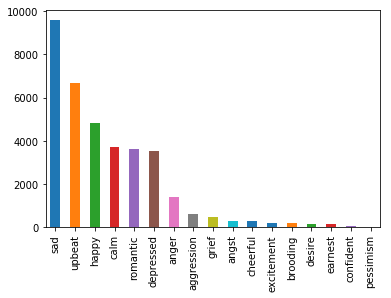

In [8]:
print('The final number of songs with a matched mood:', df.shape[0])
_ = df.mood.value_counts().plot(kind='bar')

In [ ]:
df.mood.value_counts()

## Train, Dev, & Test

With our dataset index in hand, we are prepared to split the data.

In [9]:
# thank you: https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
# optional random dataframe shuffle
#df = df.reindex(np.random.permutation(df.index))
np.random.seed(12)
def split_data(data):
    return np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

df_train, df_dev, df_test = split_data(df)

In [10]:
print('Train:', df_train.shape)
print('Dev:', df_dev.shape)
print('Test:', df_test.shape)

Train: (21501, 9)
Dev: (7167, 9)
Test: (7167, 9)


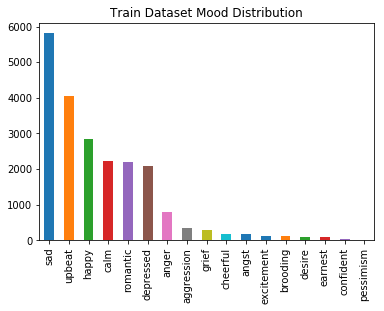

In [11]:
# thank you: https://stackoverflow.com/questions/14992644/turn-pandas-dataframe-of-strings-into-histogram
_ = df_train.mood.value_counts().plot(kind='bar', title='Train Dataset Mood Distribution')

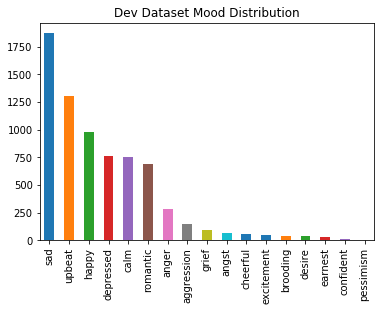

In [12]:
_ = df_dev.mood.value_counts().plot(kind='bar', title='Dev Dataset Mood Distribution')

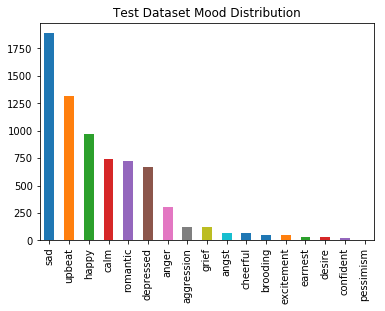

In [13]:
_ = df_test.mood.value_counts().plot(kind='bar', title='Test Dataset Mood Distribution')

## Baselines

### Most-Common-Case Classification

In [14]:
def pprint_accuracy(acc):
    return '{0:.02f}%'.format(acc * 100)

def most_common_case_classification(x, y):
    assert len(x) == len(y)
    total_count = len(x)
    common_count = y.value_counts().max()
    accuracy = common_count / total_count
    return accuracy

In [15]:
print('The most common case for each dataset split is')
print('\tTrain:', df_train.mood.value_counts().idxmax())
print('\tDev:', df_dev.mood.value_counts().idxmax())
print('\tTest:', df_test.mood.value_counts().idxmax())
#df_test.loc[df_test.mood_classes.idxmax()].mood
print('The accuracy of the most-common-case classifier for each dataset split is')
print('\tTrain:', pprint_accuracy(most_common_case_classification(df_train.lyrics_filename, df_train.mood)))
print('\tDev:', pprint_accuracy(most_common_case_classification(df_dev.lyrics_filename, df_dev.mood)))
print('\tTest:', pprint_accuracy(most_common_case_classification(df_test.lyrics_filename, df_test.mood)))


The most common case for each dataset split is
	Train: sad
	Dev: sad
	Test: sad
The accuracy of the most-common-case classifier for each dataset split is
	Train: 27.02%
	Dev: 26.11%
	Test: 26.34%


### Naive-Bayes Classification

The Naive-Bayes Classifier will require the actual lyrical text for classification, so we begin by reading into memory the text for each song in our dataset.

Once we have the lyrics, we use the python sklearn package to vectorize and process the lyrical text, fit the Naive Bayes Classifier, and compute the accuracy.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

def prep_lyrics_for_nb(lyrics_series, count_vect=None, tfidf_transformer=None):
   # thank you: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    if not count_vect:
        count_vect = CountVectorizer()
        count_vect = count_vect.fit(lyrics_series)
    x_train_counts = count_vect.transform(lyrics_series)
    if not tfidf_transformer:
        tfidf_transformer = TfidfTransformer()
        tfidf_transformer = tfidf_transformer.fit(x_train_counts)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
    return count_vect, x_train_counts, tfidf_transformer, x_train_tfidf

# convert lyrics to counts and term-frequencies
count_vect, x_train_counts, tfidf_transformer, x_train_tfidf = prep_lyrics_for_nb(df_train.lyrics)
print(x_train_tfidf.shape)
_, x_dev_counts, _, x_dev_tfidf = prep_lyrics_for_nb(df_dev.lyrics, count_vect, tfidf_transformer)
print(x_dev_tfidf.shape)
_, x_test_counts, _, x_test_tfidf = prep_lyrics_for_nb(df_test.lyrics, count_vect, tfidf_transformer)
print(x_test_tfidf.shape)

(21501, 42154)
(7167, 42154)
(7167, 42154)


In [17]:
clf = MultinomialNB().fit(x_train_tfidf, df_train.mood_cats) 
dev_acc = clf.score(x_dev_tfidf, df_dev.mood_cats)
print('Naive Bayes Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, df_test.mood_cats)
print('Naive Bayes Classifier Test Accuracy:', pprint_accuracy(test_acc))

Naive Bayes Classifier Dev Accuracy: 29.64%
Naive Bayes Classifier Test Accuracy: 30.25%


### SVM Classification

From [Corona & O'Mahony](https://www.researchgate.net/publication/280733696_An_Exploration_of_Mood_Classification_in_the_Million_Songs_Dataset), SVMs have been used with success in this area. Here we see that they do provide a sizeable increase in accuracy over NB.

In [18]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42,
            max_iter=5, tol=None).fit(x_train_tfidf, df_train.mood_cats)
dev_acc = clf.score(x_dev_tfidf, df_dev.mood_cats)
print('SVM Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, df_test.mood_cats)
print('SVM Classifier Test Accuracy:', pprint_accuracy(test_acc))

SVM Classifier Dev Accuracy: 41.61%
SVM Classifier Test Accuracy: 42.47%


## Neural Networks

### CNN

http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/

CNNs process textual input different than a Naive Bayes or SVM classifier. We perform the following data processing steps on all lyrics:
* Truncate/extend all songs to the 75% wordcount percentile
* Tokenize lyrics with nltk's word_tokenize function
* Remove all stopwords that match from within nltk's stopwords corpus
* Remove punctuation

In [20]:
pctiles = df.wordcount.describe()
print(pctiles)
cutoff = int(pctiles[pctiles.index.str.startswith('75%')][0])
print('\nAll songs will be limited to {0} words'.format(cutoff))

count    35835.000000
mean       228.451430
std        125.205067
min          1.000000
25%        147.000000
50%        207.000000
75%        282.000000
max       2913.000000
Name: wordcount, dtype: float64

All songs will be limited to 282 words


In [29]:
from importlib import reload
reload(lyrics2vec)
lyrics_vectorizer = lyrics2vec.lyrics2vec.InitFromLyrics()

In [30]:
def normalize_lyrics(lyrics, max_length, lyrics_vectorizer):
    """
    Tokenize, process, shorten/lengthen, and vectorize lyrics
    """
    lyrics = lyrics2vec.lyrics_preprocessing(lyrics)
    if len(lyrics) > max_length:
        lyrics = lyrics[:max_length]
    else:
        lyrics += ['<PAD>'] * (int(max_length) - int(len(lyrics)))

    lyric_vector = lyrics_vectorizer.transform(lyrics)
    return lyric_vector

start = time.time()

# here we make use of panda's apply function to parallelize the IO operation (again)
df_train['normalized_lyrics'] = df_train.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('train data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_train.normalized_lyrics.head())

df_dev['normalized_lyrics'] = df_dev.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('dev data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_dev.normalized_lyrics.head())

df_test['normalized_lyrics'] = df_test.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('test data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_test.normalized_lyrics.head())

print('\nExample of padding:')
example = df_train.normalized_lyrics[df_train.normalized_lyrics.str.len() == cutoff].iloc[0]
print('\tFirst 5 tokens: {0}'.format(example[:5]))
print('\tLast 5 tokens: {0}.'.format(example[-5:]))

print('\nElapsed Time: {0} minutes'.format((time.time() - start) / 60))

train data normalized (0.45991339683532717 minutes)
167425    [22, 1, 16, 6943, 5313, 6, 7, 13141, 2256, 89,...
30039     [296, 287, 215, 305, 1, 12153, 8, 297, 127, 6,...
13452     [112, 2902, 249, 763, 11223, 820, 601, 271, 18...
147252    [2, 210, 210, 13586, 70, 850, 704, 46, 159, 30...
141502    [63, 9, 101, 98, 505, 68, 172, 218, 27, 906, 6...
Name: normalized_lyrics, dtype: object
dev data normalized (0.6108621239662171 minutes)
108764    [65, 64, 1042, 449, 392, 1070, 1, 63, 23, 20, ...
200237    [417, 699, 366, 1353, 11396, 1325, 96, 812, 18...
69545     [37, 93, 15, 3458, 370, 2152, 450, 956, 970, 8...
26241     [238, 41, 86, 487, 29, 48, 312, 3, 492, 68, 30...
99874     [22, 1, 955, 9166, 399, 1273, 9166, 399, 4, 10...
Name: normalized_lyrics, dtype: object
test data normalized (0.7631547927856446 minutes)
113310    [59, 5580, 706, 59, 5580, 59, 5580, 174, 3129,...
160576    [37, 93, 1459, 544, 3950, 670, 3, 499, 2132, 3...
162776    [10909, 446, 132, 549, 96, 5859, 16, 719,

# **Following code is borrowed from [this excellent and very helpful blog post](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/) to PoC the validity of the preprocessed tokens and word embeddings**

And here's a walkthrough of that blog post's code: https://agarnitin86.github.io/blog/2016/12/23/text-classification-cnn

In [122]:
class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(
      self, sequence_length, num_classes, vocab_size,
      embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0,
      embeddings=None):

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        # for loading word2vec: https://stackoverflow.com/questions/35687678/using-a-pre-trained-word-embedding-word2vec-or-glove-in-tensorflow
        with tf.device('/cpu:0'), tf.name_scope("embedding"):

            self.pretrained_embeddings = embeddings is not None
            if self.pretrained_embeddings:
                self.W = tf.get_variable(
                    shape=embeddings.shape,
                    initializer=tf.constant_initializer(embeddings),
                    trainable=False,
                    name="W")
            else:
                self.W = tf.Variable(
                    tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                    name="W")
            
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                Wconv = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="Wconv")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    Wconv,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            Wconv = tf.get_variable(
                "Wconv",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(Wconv)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, Wconv, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [123]:
# Parameters
# ==================================================

SAVE_STEP_DATA = True
USE_TIME_AS_KEY = False

# Model Hyperparameters
embedding_dim = 300
filter_sizes = [3,4,5]
num_filters = 128
dropout_keep_prob = 0.5
l2_reg_lambda = 0.01

# Training parameters
batch_size = 64
num_epochs = 20
evaluate_every = 100
checkpoint_every = 100
num_checkpoints = 5

def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print('num_batches_per_epoch = {0}'.format(num_batches_per_epoch))
    for epoch in range(num_epochs):
        print('***********************************************')
        print('Epoch {0}/{1}\n'.format(epoch, num_epochs))
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            print('-----------------------------------------------')
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            print('Epoch {0}/{1}, Batch {2}/{3} (start={4}, end={5})'.format(
                epoch, num_epochs, batch_num, num_batches_per_epoch, start_index, end_index))
            yield shuffled_data[start_index:end_index]
            
def train(vocab_size, x_train, y_train, x_dev, y_dev, x_test, y_test, embeddings=None):
    # Training
    # ==================================================

    with tf.Graph().as_default():
        session_conf = tf.ConfigProto()
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                #vocab_size=len(vocab_processor.vocabulary_),
                vocab_size=vocab_size,
                embedding_size=embedding_dim,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda,
                embeddings=embeddings)

            # Define Training procedure
            global_step = tf.Variable(0, name="global_step", trainable=False)
            optimizer = tf.train.AdamOptimizer(1e-3)
            grads_and_vars = optimizer.compute_gradients(cnn.loss)
            train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

            # Keep track of gradient values and sparsity (optional)
            grad_summaries = []
            for g, v in grads_and_vars:
                if g is not None:
                    grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                    sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                    grad_summaries.append(grad_hist_summary)
                    grad_summaries.append(sparsity_summary)
            grad_summaries_merged = tf.summary.merge(grad_summaries)

            # Output directory for models and summaries
            if USE_TIME_AS_KEY:
                unique_key = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
            else:
                unique_key = 'Em-{0}_FS-{1}_NF-{2}_D-{3}_L2-{4}_B-{5}_Ep-{6}_W2V-{7}_V-{8}'.format(
                    embedding_dim, '-'.join(map(str, filter_sizes)), num_filters, dropout_keep_prob,
                    l2_reg_lambda, batch_size, num_epochs, 1 if cnn.pretrained_embeddings else 0, vocab_size)
            out_dir = os.path.abspath(os.path.join(lyrics2vec.LOGS_TF_DIR, "runs", unique_key))
            os.makedirs(out_dir)
            print("Writing to {}\n".format(out_dir))
            
            # dump params to json in case they need to be referenced later
            with open(os.path.join(out_dir, 'model_params.json'), 'w') as outfile:
                model_params = {
                    'embedding_dim': embedding_dim,
                    'filter_sizes': filter_sizes,
                    'num_filters': num_filters,
                    'dropout_keep_prob': dropout_keep_prob,
                    'l2_reg_lambda': l2_reg_lambda,
                    'batch_size': batch_size,
                    'num_epochs': num_epochs,
                    'evaluate_every': evaluate_every,
                    'checkpoint_every': checkpoint_every,
                    'num_checkpoints': num_checkpoints,
                    'pretrained_embeddings': cnn.pretrained_embeddings
                }
                json.dump(model_params, outfile, sort_keys=True)
                
            # Summaries for loss and accuracy
            loss_summary = tf.summary.scalar("loss", cnn.loss)
            acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

            # Train Summaries
            summary_dir = os.path.join(out_dir, "summaries")
            train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
            train_summary_writer = tf.summary.FileWriter(os.path.join(summary_dir, "train"), sess.graph)

            # Dev summaries
            dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
            dev_summary_writer = tf.summary.FileWriter(os.path.join(summary_dir, "dev"), sess.graph)

            # Test summaries
            test_summary_op = tf.summary.merge([loss_summary, acc_summary])
            test_summary_writer = tf.summary.FileWriter(os.path.join(summary_dir, "test"), sess.graph)
            
            # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

            # Write vocabulary
            #vocab_processor.save(os.path.join(out_dir, "vocab"))

            # Initialize all variables
            sess.run(tf.global_variables_initializer())

            def train_step(x_batch, y_batch, summary_writer=None, step_writer=None):
                """
                A single training step
                """
                feed_dict = {
                  cnn.input_x: x_batch,
                  cnn.input_y: y_batch,
                  cnn.dropout_keep_prob: dropout_keep_prob
                }
                _, step, summaries, loss, accuracy = sess.run(
                    [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                    feed_dict)
                time_str = datetime.datetime.now().isoformat()
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
                if summary_writer:
                    summary_writer.add_summary(summaries, step)
                if step_writer:
                    step_writer.writerow(['train', time_str, step, loss, accuracy])
                return time_str, step, loss, accuracy

            def dev_step(x_batch, y_batch, summary_writer=None, step_writer=None):
                """
                Evaluates model on a dev set
                """
                feed_dict = {
                  cnn.input_x: x_batch,
                  cnn.input_y: y_batch,
                  cnn.dropout_keep_prob: 1.0
                }
                step, summaries, loss, accuracy = sess.run(
                    [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                    feed_dict)
                time_str = datetime.datetime.now().isoformat()
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
                if summary_writer:
                    summary_writer.add_summary(summaries, step)
                if step_writer:
                    step_writer.writerow(['train', time_str, step, loss, accuracy])
                return time_str, step, loss, accuracy
                   
            csvwriter = None
            if SAVE_STEP_DATA:
                csvfile = open(os.path.join(out_dir, 'step_data.csv'), 'w')
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(['dataset', 'time', 'step', 'loss', 'acc'])
                
            # Generate batches
            batches = batch_iter(
                list(zip(x_train, y_train)), batch_size, num_epochs)
            # Training loop. For each batch...
            for batch in batches:
                x_batch, y_batch = zip(*batch)
                train_step(x_batch, y_batch, summary_writer=train_summary_writer, step_writer=csvwriter)
                current_step = tf.train.global_step(sess, global_step)
                if current_step % evaluate_every == 0:
                    print("\nEvaluation:")
                    dev_step(x_dev, y_dev, summary_writer=dev_summary_writer, step_writer=csvwriter)
                    print("")
                if current_step % checkpoint_every == 0:
                    path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                    print("Saved model checkpoint to {}\n".format(path))
                    
            print("\nFinal Test Evaluation:")
            dev_step(x_test, y_test, summary_writer=test_summary_writer, step_writer=csvwriter)


In [124]:
# get our pre-trained word2vec embeddings
lyrics_vectorizer = lyrics2vec.lyrics2vec()
embeddings_loaded = lyrics_vectorizer.load_embeddings()
if embeddings_loaded:
    print('embeddings shape:', lyrics_vectorizer.final_embeddings.shape)

embeddings shape: (50000, 300)


In [125]:
V = lyrics2vec.VOCAB_SIZE
#V = 50000
# need to convert lyrics into numpy 2d arrays
# need to convert classes into dummies
train(
    vocab_size=V,
    x_train=np.array(list(df_train.normalized_lyrics)),
    y_train=pd.get_dummies(df_train.mood).values,
    x_dev=np.array(list(df_dev.normalized_lyrics)),
    y_dev=pd.get_dummies(df_dev.mood).values,
    x_test=np.array(list(df_test.normalized_lyrics)),
    y_test=pd.get_dummies(df_test.mood).values,
    embeddings=lyrics_vectorizer.final_embeddings
)

INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/hist is illegal; using conv-maxpool-3/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/sparsity is illegal; using conv-maxpool-3/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/hist is illegal; using conv-maxpool-4/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/sparsity is illegal; using conv-maxpool-4/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/hist is illegal; using conv-maxpool-4/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/sparsity is illegal; using conv-maxpool-4/b_0/grad/sparsity instead.
INFO:tensorflow:Summary 

2018-11-25T10:44:17.944806: step 42, loss 2.31318, acc 0.21875
-----------------------------------------------
Epoch 0/20, Batch 42/672 (start=1344, end=1376)
2018-11-25T10:44:18.004229: step 43, loss 2.53424, acc 0.21875
-----------------------------------------------
Epoch 0/20, Batch 43/672 (start=1376, end=1408)
2018-11-25T10:44:18.063759: step 44, loss 2.46915, acc 0.0625
-----------------------------------------------
Epoch 0/20, Batch 44/672 (start=1408, end=1440)
2018-11-25T10:44:18.123128: step 45, loss 2.35771, acc 0.3125
-----------------------------------------------
Epoch 0/20, Batch 45/672 (start=1440, end=1472)
2018-11-25T10:44:18.182769: step 46, loss 2.17659, acc 0.3125
-----------------------------------------------
Epoch 0/20, Batch 46/672 (start=1472, end=1504)
2018-11-25T10:44:18.241957: step 47, loss 2.26523, acc 0.28125
-----------------------------------------------
Epoch 0/20, Batch 47/672 (start=1504, end=1536)
2018-11-25T10:44:18.311576: step 48, loss 2.14818

2018-11-25T10:44:21.120346: step 94, loss 2.07302, acc 0.28125
-----------------------------------------------
Epoch 0/20, Batch 94/672 (start=3008, end=3040)
2018-11-25T10:44:21.180778: step 95, loss 2.30367, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 95/672 (start=3040, end=3072)
2018-11-25T10:44:21.243196: step 96, loss 2.39688, acc 0.28125
-----------------------------------------------
Epoch 0/20, Batch 96/672 (start=3072, end=3104)
2018-11-25T10:44:21.306299: step 97, loss 2.40109, acc 0.125
-----------------------------------------------
Epoch 0/20, Batch 97/672 (start=3104, end=3136)
2018-11-25T10:44:21.366091: step 98, loss 2.49823, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 98/672 (start=3136, end=3168)
2018-11-25T10:44:21.426954: step 99, loss 2.51169, acc 0.15625
-----------------------------------------------
Epoch 0/20, Batch 99/672 (start=3168, end=3200)
2018-11-25T10:44:21.488305: step 100, loss 2.33098, ac

2018-11-25T10:44:29.550230: step 147, loss 2.44263, acc 0.125
-----------------------------------------------
Epoch 0/20, Batch 147/672 (start=4704, end=4736)
2018-11-25T10:44:29.609830: step 148, loss 2.2124, acc 0.21875
-----------------------------------------------
Epoch 0/20, Batch 148/672 (start=4736, end=4768)
2018-11-25T10:44:29.670999: step 149, loss 2.25992, acc 0.21875
-----------------------------------------------
Epoch 0/20, Batch 149/672 (start=4768, end=4800)
2018-11-25T10:44:29.733517: step 150, loss 2.42537, acc 0.1875
-----------------------------------------------
Epoch 0/20, Batch 150/672 (start=4800, end=4832)
2018-11-25T10:44:29.792648: step 151, loss 2.12431, acc 0.3125
-----------------------------------------------
Epoch 0/20, Batch 151/672 (start=4832, end=4864)
2018-11-25T10:44:29.853089: step 152, loss 1.78627, acc 0.4375
-----------------------------------------------
Epoch 0/20, Batch 152/672 (start=4864, end=4896)
2018-11-25T10:44:29.913591: step 153, lo

2018-11-25T10:44:32.738836: step 199, loss 2.3295, acc 0.1875
-----------------------------------------------
Epoch 0/20, Batch 199/672 (start=6368, end=6400)
2018-11-25T10:44:32.800527: step 200, loss 2.13502, acc 0.3125

Evaluation:
2018-11-25T10:44:37.643216: step 200, loss 2.19813, acc 0.306683

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-128_D-0.5_L2-0.01_B-32_Ep-20_W2V-1_V-50000/checkpoints/model-200

-----------------------------------------------
Epoch 0/20, Batch 200/672 (start=6400, end=6432)
2018-11-25T10:44:37.913650: step 201, loss 1.86068, acc 0.40625
-----------------------------------------------
Epoch 0/20, Batch 201/672 (start=6432, end=6464)
2018-11-25T10:44:37.973128: step 202, loss 2.37146, acc 0.1875
-----------------------------------------------
Epoch 0/20, Batch 202/672 (start=6464, end=6496)
2018-11-25T10:44:38.034318: step 203, loss 2.64644, acc 0.28125
----------------------------

2018-11-25T10:44:40.865895: step 249, loss 2.40287, acc 0.21875
-----------------------------------------------
Epoch 0/20, Batch 249/672 (start=7968, end=8000)
2018-11-25T10:44:40.926719: step 250, loss 1.99982, acc 0.34375
-----------------------------------------------
Epoch 0/20, Batch 250/672 (start=8000, end=8032)
2018-11-25T10:44:40.986417: step 251, loss 1.9527, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 251/672 (start=8032, end=8064)
2018-11-25T10:44:41.048580: step 252, loss 2.24091, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 252/672 (start=8064, end=8096)
2018-11-25T10:44:41.109710: step 253, loss 2.14231, acc 0.21875
-----------------------------------------------
Epoch 0/20, Batch 253/672 (start=8096, end=8128)
2018-11-25T10:44:41.178859: step 254, loss 2.62996, acc 0.21875
-----------------------------------------------
Epoch 0/20, Batch 254/672 (start=8128, end=8160)
2018-11-25T10:44:41.238376: step 255, los

2018-11-25T10:44:48.872666: step 300, loss 2.14861, acc 0.275708

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-128_D-0.5_L2-0.01_B-32_Ep-20_W2V-1_V-50000/checkpoints/model-300

-----------------------------------------------
Epoch 0/20, Batch 300/672 (start=9600, end=9632)
2018-11-25T10:44:49.138647: step 301, loss 2.19502, acc 0.1875
-----------------------------------------------
Epoch 0/20, Batch 301/672 (start=9632, end=9664)
2018-11-25T10:44:49.203916: step 302, loss 2.1037, acc 0.375
-----------------------------------------------
Epoch 0/20, Batch 302/672 (start=9664, end=9696)
2018-11-25T10:44:49.263564: step 303, loss 2.14762, acc 0.34375
-----------------------------------------------
Epoch 0/20, Batch 303/672 (start=9696, end=9728)
2018-11-25T10:44:49.322970: step 304, loss 2.07135, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 304/672 (start=9728, end=9760)
2018-11-25T

2018-11-25T10:44:52.328911: step 353, loss 2.21325, acc 0.28125
-----------------------------------------------
Epoch 0/20, Batch 353/672 (start=11296, end=11328)
2018-11-25T10:44:52.391019: step 354, loss 2.26312, acc 0.34375
-----------------------------------------------
Epoch 0/20, Batch 354/672 (start=11328, end=11360)
2018-11-25T10:44:52.451233: step 355, loss 2.19359, acc 0.15625
-----------------------------------------------
Epoch 0/20, Batch 355/672 (start=11360, end=11392)
2018-11-25T10:44:52.510458: step 356, loss 2.13223, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 356/672 (start=11392, end=11424)
2018-11-25T10:44:52.571048: step 357, loss 2.34779, acc 0.09375
-----------------------------------------------
Epoch 0/20, Batch 357/672 (start=11424, end=11456)
2018-11-25T10:44:52.633116: step 358, loss 2.51833, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 358/672 (start=11456, end=11488)
2018-11-25T10:44:52.693965: 

2018-11-25T10:45:00.558002: step 405, loss 2.44793, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 405/672 (start=12960, end=12992)
2018-11-25T10:45:00.621657: step 406, loss 2.01488, acc 0.3125
-----------------------------------------------
Epoch 0/20, Batch 406/672 (start=12992, end=13024)
2018-11-25T10:45:00.685878: step 407, loss 2.43422, acc 0.3125
-----------------------------------------------
Epoch 0/20, Batch 407/672 (start=13024, end=13056)
2018-11-25T10:45:00.746067: step 408, loss 2.55596, acc 0.125
-----------------------------------------------
Epoch 0/20, Batch 408/672 (start=13056, end=13088)
2018-11-25T10:45:00.804695: step 409, loss 2.14709, acc 0.34375
-----------------------------------------------
Epoch 0/20, Batch 409/672 (start=13088, end=13120)
2018-11-25T10:45:00.865823: step 410, loss 2.18952, acc 0.21875
-----------------------------------------------
Epoch 0/20, Batch 410/672 (start=13120, end=13152)
2018-11-25T10:45:00.928255: s

2018-11-25T10:45:03.757036: step 457, loss 2.19553, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 457/672 (start=14624, end=14656)
2018-11-25T10:45:03.816856: step 458, loss 2.31346, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 458/672 (start=14656, end=14688)
2018-11-25T10:45:03.876086: step 459, loss 2.37439, acc 0.15625
-----------------------------------------------
Epoch 0/20, Batch 459/672 (start=14688, end=14720)
2018-11-25T10:45:03.936332: step 460, loss 2.18358, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 460/672 (start=14720, end=14752)
2018-11-25T10:45:04.001254: step 461, loss 2.15734, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 461/672 (start=14752, end=14784)
2018-11-25T10:45:04.059519: step 462, loss 2.52531, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 462/672 (start=14784, end=14816)
2018-11-25T10:45:04.121376: step 463,

2018-11-25T10:45:11.957966: step 509, loss 1.86568, acc 0.34375
-----------------------------------------------
Epoch 0/20, Batch 509/672 (start=16288, end=16320)
2018-11-25T10:45:12.025374: step 510, loss 2.00686, acc 0.375
-----------------------------------------------
Epoch 0/20, Batch 510/672 (start=16320, end=16352)
2018-11-25T10:45:12.085816: step 511, loss 1.9452, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 511/672 (start=16352, end=16384)
2018-11-25T10:45:12.152112: step 512, loss 2.03326, acc 0.3125
-----------------------------------------------
Epoch 0/20, Batch 512/672 (start=16384, end=16416)
2018-11-25T10:45:12.212915: step 513, loss 2.01267, acc 0.28125
-----------------------------------------------
Epoch 0/20, Batch 513/672 (start=16416, end=16448)
2018-11-25T10:45:12.272873: step 514, loss 1.98986, acc 0.3125
-----------------------------------------------
Epoch 0/20, Batch 514/672 (start=16448, end=16480)
2018-11-25T10:45:12.333316: st

2018-11-25T10:45:15.153539: step 561, loss 1.84125, acc 0.3125
-----------------------------------------------
Epoch 0/20, Batch 561/672 (start=17952, end=17984)
2018-11-25T10:45:15.214156: step 562, loss 2.47751, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 562/672 (start=17984, end=18016)
2018-11-25T10:45:15.274676: step 563, loss 2.11964, acc 0.15625
-----------------------------------------------
Epoch 0/20, Batch 563/672 (start=18016, end=18048)
2018-11-25T10:45:15.333522: step 564, loss 2.06998, acc 0.375
-----------------------------------------------
Epoch 0/20, Batch 564/672 (start=18048, end=18080)
2018-11-25T10:45:15.392951: step 565, loss 2.17884, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 565/672 (start=18080, end=18112)
2018-11-25T10:45:15.452233: step 566, loss 1.88571, acc 0.40625
-----------------------------------------------
Epoch 0/20, Batch 566/672 (start=18112, end=18144)
2018-11-25T10:45:15.511333: ste

2018-11-25T10:45:23.368638: step 612, loss 2.30818, acc 0.15625
-----------------------------------------------
Epoch 0/20, Batch 612/672 (start=19584, end=19616)
2018-11-25T10:45:23.428542: step 613, loss 2.04001, acc 0.34375
-----------------------------------------------
Epoch 0/20, Batch 613/672 (start=19616, end=19648)
2018-11-25T10:45:23.491452: step 614, loss 2.1159, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 614/672 (start=19648, end=19680)
2018-11-25T10:45:23.550807: step 615, loss 2.05392, acc 0.21875
-----------------------------------------------
Epoch 0/20, Batch 615/672 (start=19680, end=19712)
2018-11-25T10:45:23.610493: step 616, loss 2.08564, acc 0.40625
-----------------------------------------------
Epoch 0/20, Batch 616/672 (start=19712, end=19744)
2018-11-25T10:45:23.669949: step 617, loss 2.3294, acc 0.3125
-----------------------------------------------
Epoch 0/20, Batch 617/672 (start=19744, end=19776)
2018-11-25T10:45:23.729661: 

2018-11-25T10:45:26.527351: step 664, loss 1.92583, acc 0.40625
-----------------------------------------------
Epoch 0/20, Batch 664/672 (start=21248, end=21280)
2018-11-25T10:45:26.586637: step 665, loss 1.87845, acc 0.3125
-----------------------------------------------
Epoch 0/20, Batch 665/672 (start=21280, end=21312)
2018-11-25T10:45:26.646382: step 666, loss 1.86101, acc 0.375
-----------------------------------------------
Epoch 0/20, Batch 666/672 (start=21312, end=21344)
2018-11-25T10:45:26.707262: step 667, loss 1.93824, acc 0.34375
-----------------------------------------------
Epoch 0/20, Batch 667/672 (start=21344, end=21376)
2018-11-25T10:45:26.766791: step 668, loss 2.18376, acc 0.28125
-----------------------------------------------
Epoch 0/20, Batch 668/672 (start=21376, end=21408)
2018-11-25T10:45:26.828801: step 669, loss 1.8512, acc 0.40625
-----------------------------------------------
Epoch 0/20, Batch 669/672 (start=21408, end=21440)
2018-11-25T10:45:26.889147

2018-11-25T10:45:34.761098: step 716, loss 1.80012, acc 0.28125
-----------------------------------------------
Epoch 1/20, Batch 44/672 (start=1408, end=1440)
2018-11-25T10:45:34.819967: step 717, loss 2.13375, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 45/672 (start=1440, end=1472)
2018-11-25T10:45:34.887493: step 718, loss 1.75207, acc 0.5
-----------------------------------------------
Epoch 1/20, Batch 46/672 (start=1472, end=1504)
2018-11-25T10:45:34.949365: step 719, loss 2.07567, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 47/672 (start=1504, end=1536)
2018-11-25T10:45:35.011083: step 720, loss 1.69806, acc 0.4375
-----------------------------------------------
Epoch 1/20, Batch 48/672 (start=1536, end=1568)
2018-11-25T10:45:35.073814: step 721, loss 1.90994, acc 0.46875
-----------------------------------------------
Epoch 1/20, Batch 49/672 (start=1568, end=1600)
2018-11-25T10:45:35.135613: step 722, loss 2.

2018-11-25T10:45:37.954930: step 768, loss 1.78756, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 96/672 (start=3072, end=3104)
2018-11-25T10:45:38.016849: step 769, loss 1.973, acc 0.3125
-----------------------------------------------
Epoch 1/20, Batch 97/672 (start=3104, end=3136)
2018-11-25T10:45:38.076688: step 770, loss 2.30787, acc 0.21875
-----------------------------------------------
Epoch 1/20, Batch 98/672 (start=3136, end=3168)
2018-11-25T10:45:38.136617: step 771, loss 2.04178, acc 0.3125
-----------------------------------------------
Epoch 1/20, Batch 99/672 (start=3168, end=3200)
2018-11-25T10:45:38.200025: step 772, loss 2.10144, acc 0.40625
-----------------------------------------------
Epoch 1/20, Batch 100/672 (start=3200, end=3232)
2018-11-25T10:45:38.258651: step 773, loss 2.2511, acc 0.3125
-----------------------------------------------
Epoch 1/20, Batch 101/672 (start=3232, end=3264)
2018-11-25T10:45:38.317942: step 774, loss 1

2018-11-25T10:45:46.213866: step 820, loss 1.8052, acc 0.40625
-----------------------------------------------
Epoch 1/20, Batch 148/672 (start=4736, end=4768)
2018-11-25T10:45:46.275968: step 821, loss 2.42979, acc 0.28125
-----------------------------------------------
Epoch 1/20, Batch 149/672 (start=4768, end=4800)
2018-11-25T10:45:46.336124: step 822, loss 1.99089, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 150/672 (start=4800, end=4832)
2018-11-25T10:45:46.397744: step 823, loss 1.99226, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 151/672 (start=4832, end=4864)
2018-11-25T10:45:46.458776: step 824, loss 2.39726, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 152/672 (start=4864, end=4896)
2018-11-25T10:45:46.518158: step 825, loss 1.94044, acc 0.28125
-----------------------------------------------
Epoch 1/20, Batch 153/672 (start=4896, end=4928)
2018-11-25T10:45:46.578807: step 82

2018-11-25T10:45:49.408411: step 872, loss 1.99999, acc 0.21875
-----------------------------------------------
Epoch 1/20, Batch 200/672 (start=6400, end=6432)
2018-11-25T10:45:49.472147: step 873, loss 2.07385, acc 0.21875
-----------------------------------------------
Epoch 1/20, Batch 201/672 (start=6432, end=6464)
2018-11-25T10:45:49.532367: step 874, loss 2.02448, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 202/672 (start=6464, end=6496)
2018-11-25T10:45:49.591630: step 875, loss 1.88487, acc 0.3125
-----------------------------------------------
Epoch 1/20, Batch 203/672 (start=6496, end=6528)
2018-11-25T10:45:49.650735: step 876, loss 2.07651, acc 0.28125
-----------------------------------------------
Epoch 1/20, Batch 204/672 (start=6528, end=6560)
2018-11-25T10:45:49.717594: step 877, loss 1.74033, acc 0.5
-----------------------------------------------
Epoch 1/20, Batch 205/672 (start=6560, end=6592)
2018-11-25T10:45:49.776181: step 878, l

2018-11-25T10:45:57.888902: step 925, loss 1.95353, acc 0.3125
-----------------------------------------------
Epoch 1/20, Batch 253/672 (start=8096, end=8128)
2018-11-25T10:45:57.950617: step 926, loss 1.99601, acc 0.375
-----------------------------------------------
Epoch 1/20, Batch 254/672 (start=8128, end=8160)
2018-11-25T10:45:58.010027: step 927, loss 1.82068, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 255/672 (start=8160, end=8192)
2018-11-25T10:45:58.069196: step 928, loss 1.84942, acc 0.46875
-----------------------------------------------
Epoch 1/20, Batch 256/672 (start=8192, end=8224)
2018-11-25T10:45:58.141651: step 929, loss 2.33478, acc 0.25
-----------------------------------------------
Epoch 1/20, Batch 257/672 (start=8224, end=8256)
2018-11-25T10:45:58.204032: step 930, loss 1.93703, acc 0.3125
-----------------------------------------------
Epoch 1/20, Batch 258/672 (start=8256, end=8288)
2018-11-25T10:45:58.263615: step 931, los

2018-11-25T10:46:01.076196: step 977, loss 1.57368, acc 0.375
-----------------------------------------------
Epoch 1/20, Batch 305/672 (start=9760, end=9792)
2018-11-25T10:46:01.135070: step 978, loss 1.8279, acc 0.46875
-----------------------------------------------
Epoch 1/20, Batch 306/672 (start=9792, end=9824)
2018-11-25T10:46:01.195084: step 979, loss 1.92645, acc 0.40625
-----------------------------------------------
Epoch 1/20, Batch 307/672 (start=9824, end=9856)
2018-11-25T10:46:01.255084: step 980, loss 1.78805, acc 0.5
-----------------------------------------------
Epoch 1/20, Batch 308/672 (start=9856, end=9888)
2018-11-25T10:46:01.325226: step 981, loss 2.17006, acc 0.25
-----------------------------------------------
Epoch 1/20, Batch 309/672 (start=9888, end=9920)
2018-11-25T10:46:01.384490: step 982, loss 1.58976, acc 0.4375
-----------------------------------------------
Epoch 1/20, Batch 310/672 (start=9920, end=9952)
2018-11-25T10:46:01.443140: step 983, loss 2.

2018-11-25T10:46:09.265470: step 1028, loss 1.93357, acc 0.40625
-----------------------------------------------
Epoch 1/20, Batch 356/672 (start=11392, end=11424)
2018-11-25T10:46:09.325275: step 1029, loss 2.0731, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 357/672 (start=11424, end=11456)
2018-11-25T10:46:09.385778: step 1030, loss 2.25578, acc 0.25
-----------------------------------------------
Epoch 1/20, Batch 358/672 (start=11456, end=11488)
2018-11-25T10:46:09.446591: step 1031, loss 1.9711, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 359/672 (start=11488, end=11520)
2018-11-25T10:46:09.504683: step 1032, loss 2.20904, acc 0.28125
-----------------------------------------------
Epoch 1/20, Batch 360/672 (start=11520, end=11552)
2018-11-25T10:46:09.565152: step 1033, loss 2.12186, acc 0.21875
-----------------------------------------------
Epoch 1/20, Batch 361/672 (start=11552, end=11584)
2018-11-25T10:46:09.6

2018-11-25T10:46:12.441925: step 1080, loss 1.86278, acc 0.4375
-----------------------------------------------
Epoch 1/20, Batch 408/672 (start=13056, end=13088)
2018-11-25T10:46:12.501883: step 1081, loss 1.847, acc 0.46875
-----------------------------------------------
Epoch 1/20, Batch 409/672 (start=13088, end=13120)
2018-11-25T10:46:12.566075: step 1082, loss 1.82573, acc 0.3125
-----------------------------------------------
Epoch 1/20, Batch 410/672 (start=13120, end=13152)
2018-11-25T10:46:12.625826: step 1083, loss 2.36108, acc 0.25
-----------------------------------------------
Epoch 1/20, Batch 411/672 (start=13152, end=13184)
2018-11-25T10:46:12.686897: step 1084, loss 1.86069, acc 0.4375
-----------------------------------------------
Epoch 1/20, Batch 412/672 (start=13184, end=13216)
2018-11-25T10:46:12.745442: step 1085, loss 1.9289, acc 0.375
-----------------------------------------------
Epoch 1/20, Batch 413/672 (start=13216, end=13248)
2018-11-25T10:46:12.806716:

2018-11-25T10:46:20.654559: step 1132, loss 1.8415, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 460/672 (start=14720, end=14752)
2018-11-25T10:46:20.714260: step 1133, loss 1.89201, acc 0.5
-----------------------------------------------
Epoch 1/20, Batch 461/672 (start=14752, end=14784)
2018-11-25T10:46:20.773854: step 1134, loss 1.70292, acc 0.28125
-----------------------------------------------
Epoch 1/20, Batch 462/672 (start=14784, end=14816)
2018-11-25T10:46:20.833576: step 1135, loss 2.1439, acc 0.21875
-----------------------------------------------
Epoch 1/20, Batch 463/672 (start=14816, end=14848)
2018-11-25T10:46:20.892601: step 1136, loss 1.80561, acc 0.4375
-----------------------------------------------
Epoch 1/20, Batch 464/672 (start=14848, end=14880)
2018-11-25T10:46:20.958995: step 1137, loss 1.76373, acc 0.5
-----------------------------------------------
Epoch 1/20, Batch 465/672 (start=14880, end=14912)
2018-11-25T10:46:21.020169:

2018-11-25T10:46:23.832979: step 1184, loss 1.90605, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 512/672 (start=16384, end=16416)
2018-11-25T10:46:23.896638: step 1185, loss 2.00038, acc 0.375
-----------------------------------------------
Epoch 1/20, Batch 513/672 (start=16416, end=16448)
2018-11-25T10:46:23.956553: step 1186, loss 1.6832, acc 0.5
-----------------------------------------------
Epoch 1/20, Batch 514/672 (start=16448, end=16480)
2018-11-25T10:46:24.016653: step 1187, loss 2.01123, acc 0.3125
-----------------------------------------------
Epoch 1/20, Batch 515/672 (start=16480, end=16512)
2018-11-25T10:46:24.076010: step 1188, loss 2.06887, acc 0.3125
-----------------------------------------------
Epoch 1/20, Batch 516/672 (start=16512, end=16544)
2018-11-25T10:46:24.142673: step 1189, loss 2.02443, acc 0.375
-----------------------------------------------
Epoch 1/20, Batch 517/672 (start=16544, end=16576)
2018-11-25T10:46:24.202604:

2018-11-25T10:46:32.082130: step 1236, loss 1.7807, acc 0.40625
-----------------------------------------------
Epoch 1/20, Batch 564/672 (start=18048, end=18080)
2018-11-25T10:46:32.143909: step 1237, loss 2.36673, acc 0.21875
-----------------------------------------------
Epoch 1/20, Batch 565/672 (start=18080, end=18112)
2018-11-25T10:46:32.205145: step 1238, loss 1.56871, acc 0.5
-----------------------------------------------
Epoch 1/20, Batch 566/672 (start=18112, end=18144)
2018-11-25T10:46:32.265577: step 1239, loss 1.73672, acc 0.40625
-----------------------------------------------
Epoch 1/20, Batch 567/672 (start=18144, end=18176)
2018-11-25T10:46:32.325702: step 1240, loss 1.93147, acc 0.28125
-----------------------------------------------
Epoch 1/20, Batch 568/672 (start=18176, end=18208)
2018-11-25T10:46:32.387393: step 1241, loss 2.13443, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 569/672 (start=18208, end=18240)
2018-11-25T10:46:32.4

2018-11-25T10:46:35.278027: step 1288, loss 1.7766, acc 0.4375
-----------------------------------------------
Epoch 1/20, Batch 616/672 (start=19712, end=19744)
2018-11-25T10:46:35.337560: step 1289, loss 2.1347, acc 0.3125
-----------------------------------------------
Epoch 1/20, Batch 617/672 (start=19744, end=19776)
2018-11-25T10:46:35.405614: step 1290, loss 1.82854, acc 0.4375
-----------------------------------------------
Epoch 1/20, Batch 618/672 (start=19776, end=19808)
2018-11-25T10:46:35.465660: step 1291, loss 1.87573, acc 0.46875
-----------------------------------------------
Epoch 1/20, Batch 619/672 (start=19808, end=19840)
2018-11-25T10:46:35.525229: step 1292, loss 1.93972, acc 0.40625
-----------------------------------------------
Epoch 1/20, Batch 620/672 (start=19840, end=19872)
2018-11-25T10:46:35.585411: step 1293, loss 2.01604, acc 0.40625
-----------------------------------------------
Epoch 1/20, Batch 621/672 (start=19872, end=19904)
2018-11-25T10:46:35.6

2018-11-25T10:46:43.512773: step 1340, loss 1.89998, acc 0.375
-----------------------------------------------
Epoch 1/20, Batch 668/672 (start=21376, end=21408)
2018-11-25T10:46:43.574693: step 1341, loss 1.96404, acc 0.4375
-----------------------------------------------
Epoch 1/20, Batch 669/672 (start=21408, end=21440)
2018-11-25T10:46:43.633824: step 1342, loss 1.89538, acc 0.28125
-----------------------------------------------
Epoch 1/20, Batch 670/672 (start=21440, end=21472)
2018-11-25T10:46:43.693880: step 1343, loss 1.82935, acc 0.4375
-----------------------------------------------
Epoch 1/20, Batch 671/672 (start=21472, end=21501)
2018-11-25T10:46:43.751741: step 1344, loss 2.19, acc 0.206897
***********************************************
Epoch 2/20

-----------------------------------------------
Epoch 2/20, Batch 0/672 (start=0, end=32)
2018-11-25T10:46:43.826053: step 1345, loss 1.76381, acc 0.5
-----------------------------------------------
Epoch 2/20, Batch 1/672 (s

2018-11-25T10:46:46.693959: step 1392, loss 2.0026, acc 0.25
-----------------------------------------------
Epoch 2/20, Batch 48/672 (start=1536, end=1568)
2018-11-25T10:46:46.755015: step 1393, loss 1.9666, acc 0.40625
-----------------------------------------------
Epoch 2/20, Batch 49/672 (start=1568, end=1600)
2018-11-25T10:46:46.817671: step 1394, loss 1.75179, acc 0.4375
-----------------------------------------------
Epoch 2/20, Batch 50/672 (start=1600, end=1632)
2018-11-25T10:46:46.878068: step 1395, loss 1.82186, acc 0.5
-----------------------------------------------
Epoch 2/20, Batch 51/672 (start=1632, end=1664)
2018-11-25T10:46:46.937858: step 1396, loss 1.92469, acc 0.375
-----------------------------------------------
Epoch 2/20, Batch 52/672 (start=1664, end=1696)
2018-11-25T10:46:47.007660: step 1397, loss 1.74478, acc 0.4375
-----------------------------------------------
Epoch 2/20, Batch 53/672 (start=1696, end=1728)
2018-11-25T10:46:47.073263: step 1398, loss 1.7

2018-11-25T10:46:55.078472: step 1445, loss 1.69998, acc 0.53125
-----------------------------------------------
Epoch 2/20, Batch 101/672 (start=3232, end=3264)
2018-11-25T10:46:55.139943: step 1446, loss 1.8782, acc 0.375
-----------------------------------------------
Epoch 2/20, Batch 102/672 (start=3264, end=3296)
2018-11-25T10:46:55.200523: step 1447, loss 1.52725, acc 0.6875
-----------------------------------------------
Epoch 2/20, Batch 103/672 (start=3296, end=3328)
2018-11-25T10:46:55.262077: step 1448, loss 1.63161, acc 0.5
-----------------------------------------------
Epoch 2/20, Batch 104/672 (start=3328, end=3360)
2018-11-25T10:46:55.323531: step 1449, loss 1.80758, acc 0.5
-----------------------------------------------
Epoch 2/20, Batch 105/672 (start=3360, end=3392)
2018-11-25T10:46:55.383691: step 1450, loss 1.60865, acc 0.5
-----------------------------------------------
Epoch 2/20, Batch 106/672 (start=3392, end=3424)
2018-11-25T10:46:55.447818: step 1451, loss 

2018-11-25T10:46:58.269239: step 1497, loss 1.79312, acc 0.46875
-----------------------------------------------
Epoch 2/20, Batch 153/672 (start=4896, end=4928)
2018-11-25T10:46:58.328935: step 1498, loss 1.85767, acc 0.46875
-----------------------------------------------
Epoch 2/20, Batch 154/672 (start=4928, end=4960)
2018-11-25T10:46:58.388200: step 1499, loss 1.80679, acc 0.34375
-----------------------------------------------
Epoch 2/20, Batch 155/672 (start=4960, end=4992)
2018-11-25T10:46:58.448271: step 1500, loss 1.78333, acc 0.4375

Evaluation:
2018-11-25T10:47:03.532373: step 1500, loss 1.96779, acc 0.359983

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-128_D-0.5_L2-0.01_B-32_Ep-20_W2V-1_V-50000/checkpoints/model-1500

-----------------------------------------------
Epoch 2/20, Batch 156/672 (start=4992, end=5024)
2018-11-25T10:47:03.821873: step 1501, loss 1.97177, acc 0.3125
-------------------

2018-11-25T10:47:06.692847: step 1548, loss 1.63295, acc 0.5625
-----------------------------------------------
Epoch 2/20, Batch 204/672 (start=6528, end=6560)
2018-11-25T10:47:06.754370: step 1549, loss 1.8103, acc 0.3125
-----------------------------------------------
Epoch 2/20, Batch 205/672 (start=6560, end=6592)
2018-11-25T10:47:06.816661: step 1550, loss 1.78104, acc 0.46875
-----------------------------------------------
Epoch 2/20, Batch 206/672 (start=6592, end=6624)
2018-11-25T10:47:06.877426: step 1551, loss 1.81441, acc 0.40625
-----------------------------------------------
Epoch 2/20, Batch 207/672 (start=6624, end=6656)
2018-11-25T10:47:06.938801: step 1552, loss 2.12208, acc 0.375
-----------------------------------------------
Epoch 2/20, Batch 208/672 (start=6656, end=6688)
2018-11-25T10:47:06.997710: step 1553, loss 1.76401, acc 0.4375
-----------------------------------------------
Epoch 2/20, Batch 209/672 (start=6688, end=6720)
2018-11-25T10:47:07.055602: step 1

2018-11-25T10:47:09.884311: step 1600, loss 1.87939, acc 0.34375

Evaluation:
2018-11-25T10:47:14.863233: step 1600, loss 1.96001, acc 0.364588

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-128_D-0.5_L2-0.01_B-32_Ep-20_W2V-1_V-50000/checkpoints/model-1600

-----------------------------------------------
Epoch 2/20, Batch 256/672 (start=8192, end=8224)
2018-11-25T10:47:15.154195: step 1601, loss 1.80615, acc 0.4375
-----------------------------------------------
Epoch 2/20, Batch 257/672 (start=8224, end=8256)
2018-11-25T10:47:15.217974: step 1602, loss 1.92235, acc 0.375
-----------------------------------------------
Epoch 2/20, Batch 258/672 (start=8256, end=8288)
2018-11-25T10:47:15.278342: step 1603, loss 1.75468, acc 0.34375
-----------------------------------------------
Epoch 2/20, Batch 259/672 (start=8288, end=8320)
2018-11-25T10:47:15.340330: step 1604, loss 1.57189, acc 0.59375
--------------------

2018-11-25T10:47:18.215749: step 1651, loss 1.65176, acc 0.4375
-----------------------------------------------
Epoch 2/20, Batch 307/672 (start=9824, end=9856)
2018-11-25T10:47:18.285726: step 1652, loss 2.00463, acc 0.3125
-----------------------------------------------
Epoch 2/20, Batch 308/672 (start=9856, end=9888)
2018-11-25T10:47:18.346489: step 1653, loss 1.7459, acc 0.375
-----------------------------------------------
Epoch 2/20, Batch 309/672 (start=9888, end=9920)
2018-11-25T10:47:18.406151: step 1654, loss 1.70983, acc 0.4375
-----------------------------------------------
Epoch 2/20, Batch 310/672 (start=9920, end=9952)
2018-11-25T10:47:18.468639: step 1655, loss 1.84374, acc 0.4375
-----------------------------------------------
Epoch 2/20, Batch 311/672 (start=9952, end=9984)
2018-11-25T10:47:18.533146: step 1656, loss 1.86877, acc 0.375
-----------------------------------------------
Epoch 2/20, Batch 312/672 (start=9984, end=10016)
2018-11-25T10:47:18.593043: step 165

2018-11-25T10:47:26.604151: step 1704, loss 1.79808, acc 0.53125
-----------------------------------------------
Epoch 2/20, Batch 360/672 (start=11520, end=11552)
2018-11-25T10:47:26.669373: step 1705, loss 1.79586, acc 0.375
-----------------------------------------------
Epoch 2/20, Batch 361/672 (start=11552, end=11584)
2018-11-25T10:47:26.729060: step 1706, loss 1.64879, acc 0.46875
-----------------------------------------------
Epoch 2/20, Batch 362/672 (start=11584, end=11616)
2018-11-25T10:47:26.789094: step 1707, loss 1.79473, acc 0.40625
-----------------------------------------------
Epoch 2/20, Batch 363/672 (start=11616, end=11648)
2018-11-25T10:47:26.848819: step 1708, loss 1.87007, acc 0.4375
-----------------------------------------------
Epoch 2/20, Batch 364/672 (start=11648, end=11680)
2018-11-25T10:47:26.908677: step 1709, loss 1.83486, acc 0.4375
-----------------------------------------------
Epoch 2/20, Batch 365/672 (start=11680, end=11712)
2018-11-25T10:47:26.

2018-11-25T10:47:29.783745: step 1756, loss 1.68967, acc 0.46875
-----------------------------------------------
Epoch 2/20, Batch 412/672 (start=13184, end=13216)
2018-11-25T10:47:29.842423: step 1757, loss 1.6007, acc 0.46875
-----------------------------------------------
Epoch 2/20, Batch 413/672 (start=13216, end=13248)
2018-11-25T10:47:29.902460: step 1758, loss 1.60004, acc 0.5625
-----------------------------------------------
Epoch 2/20, Batch 414/672 (start=13248, end=13280)
2018-11-25T10:47:29.962102: step 1759, loss 1.75773, acc 0.40625
-----------------------------------------------
Epoch 2/20, Batch 415/672 (start=13280, end=13312)
2018-11-25T10:47:30.023229: step 1760, loss 1.9212, acc 0.34375
-----------------------------------------------
Epoch 2/20, Batch 416/672 (start=13312, end=13344)
2018-11-25T10:47:30.083349: step 1761, loss 1.70401, acc 0.46875
-----------------------------------------------
Epoch 2/20, Batch 417/672 (start=13344, end=13376)
2018-11-25T10:47:30

2018-11-25T10:47:38.076972: step 1808, loss 1.68869, acc 0.4375
-----------------------------------------------
Epoch 2/20, Batch 464/672 (start=14848, end=14880)
2018-11-25T10:47:38.138232: step 1809, loss 1.48531, acc 0.5
-----------------------------------------------
Epoch 2/20, Batch 465/672 (start=14880, end=14912)
2018-11-25T10:47:38.197032: step 1810, loss 1.87258, acc 0.53125
-----------------------------------------------
Epoch 2/20, Batch 466/672 (start=14912, end=14944)
2018-11-25T10:47:38.257500: step 1811, loss 1.71294, acc 0.40625
-----------------------------------------------
Epoch 2/20, Batch 467/672 (start=14944, end=14976)
2018-11-25T10:47:38.317623: step 1812, loss 2.03623, acc 0.40625
-----------------------------------------------
Epoch 2/20, Batch 468/672 (start=14976, end=15008)
2018-11-25T10:47:38.378205: step 1813, loss 2.01585, acc 0.375
-----------------------------------------------
Epoch 2/20, Batch 469/672 (start=15008, end=15040)
2018-11-25T10:47:38.439

2018-11-25T10:47:41.254934: step 1860, loss 2.04489, acc 0.40625
-----------------------------------------------
Epoch 2/20, Batch 516/672 (start=16512, end=16544)
2018-11-25T10:47:41.315232: step 1861, loss 1.92199, acc 0.4375
-----------------------------------------------
Epoch 2/20, Batch 517/672 (start=16544, end=16576)
2018-11-25T10:47:41.374317: step 1862, loss 2.00747, acc 0.34375
-----------------------------------------------
Epoch 2/20, Batch 518/672 (start=16576, end=16608)
2018-11-25T10:47:41.433446: step 1863, loss 1.95107, acc 0.5
-----------------------------------------------
Epoch 2/20, Batch 519/672 (start=16608, end=16640)
2018-11-25T10:47:41.502962: step 1864, loss 1.71979, acc 0.53125
-----------------------------------------------
Epoch 2/20, Batch 520/672 (start=16640, end=16672)
2018-11-25T10:47:41.564453: step 1865, loss 1.78819, acc 0.5625
-----------------------------------------------
Epoch 2/20, Batch 521/672 (start=16672, end=16704)
2018-11-25T10:47:41.62

2018-11-25T10:47:49.415408: step 1909, loss 1.65221, acc 0.46875
-----------------------------------------------
Epoch 2/20, Batch 565/672 (start=18080, end=18112)
2018-11-25T10:47:49.474448: step 1910, loss 1.85722, acc 0.53125
-----------------------------------------------
Epoch 2/20, Batch 566/672 (start=18112, end=18144)
2018-11-25T10:47:49.541285: step 1911, loss 1.6846, acc 0.5
-----------------------------------------------
Epoch 2/20, Batch 567/672 (start=18144, end=18176)
2018-11-25T10:47:49.602150: step 1912, loss 1.951, acc 0.5
-----------------------------------------------
Epoch 2/20, Batch 568/672 (start=18176, end=18208)
2018-11-25T10:47:49.661202: step 1913, loss 1.83004, acc 0.4375
-----------------------------------------------
Epoch 2/20, Batch 569/672 (start=18208, end=18240)
2018-11-25T10:47:49.723641: step 1914, loss 1.70651, acc 0.4375
-----------------------------------------------
Epoch 2/20, Batch 570/672 (start=18240, end=18272)
2018-11-25T10:47:49.782474: s

2018-11-25T10:47:52.604883: step 1961, loss 2.16244, acc 0.46875
-----------------------------------------------
Epoch 2/20, Batch 617/672 (start=19744, end=19776)
2018-11-25T10:47:52.665439: step 1962, loss 1.79392, acc 0.34375
-----------------------------------------------
Epoch 2/20, Batch 618/672 (start=19776, end=19808)
2018-11-25T10:47:52.727138: step 1963, loss 1.9018, acc 0.46875
-----------------------------------------------
Epoch 2/20, Batch 619/672 (start=19808, end=19840)
2018-11-25T10:47:52.792154: step 1964, loss 1.96784, acc 0.21875
-----------------------------------------------
Epoch 2/20, Batch 620/672 (start=19840, end=19872)
2018-11-25T10:47:52.851830: step 1965, loss 1.83545, acc 0.3125
-----------------------------------------------
Epoch 2/20, Batch 621/672 (start=19872, end=19904)
2018-11-25T10:47:52.912103: step 1966, loss 1.50991, acc 0.53125
-----------------------------------------------
Epoch 2/20, Batch 622/672 (start=19904, end=19936)
2018-11-25T10:47:5

2018-11-25T10:48:00.871737: step 2012, loss 1.62143, acc 0.40625
-----------------------------------------------
Epoch 2/20, Batch 668/672 (start=21376, end=21408)
2018-11-25T10:48:00.933133: step 2013, loss 2.17412, acc 0.28125
-----------------------------------------------
Epoch 2/20, Batch 669/672 (start=21408, end=21440)
2018-11-25T10:48:00.992871: step 2014, loss 1.83895, acc 0.40625
-----------------------------------------------
Epoch 2/20, Batch 670/672 (start=21440, end=21472)
2018-11-25T10:48:01.052389: step 2015, loss 2.00334, acc 0.25
-----------------------------------------------
Epoch 2/20, Batch 671/672 (start=21472, end=21501)
2018-11-25T10:48:01.107078: step 2016, loss 1.85596, acc 0.413793
***********************************************
Epoch 3/20

-----------------------------------------------
Epoch 3/20, Batch 0/672 (start=0, end=32)
2018-11-25T10:48:01.172084: step 2017, loss 2.13254, acc 0.375
-----------------------------------------------
Epoch 3/20, Batch 1/

2018-11-25T10:48:04.053293: step 2064, loss 1.70261, acc 0.65625
-----------------------------------------------
Epoch 3/20, Batch 48/672 (start=1536, end=1568)
2018-11-25T10:48:04.115660: step 2065, loss 1.54877, acc 0.5
-----------------------------------------------
Epoch 3/20, Batch 49/672 (start=1568, end=1600)
2018-11-25T10:48:04.175582: step 2066, loss 1.61076, acc 0.59375
-----------------------------------------------
Epoch 3/20, Batch 50/672 (start=1600, end=1632)
2018-11-25T10:48:04.237135: step 2067, loss 1.66807, acc 0.59375
-----------------------------------------------
Epoch 3/20, Batch 51/672 (start=1632, end=1664)
2018-11-25T10:48:04.302169: step 2068, loss 1.56466, acc 0.5
-----------------------------------------------
Epoch 3/20, Batch 52/672 (start=1664, end=1696)
2018-11-25T10:48:04.370784: step 2069, loss 1.66846, acc 0.46875
-----------------------------------------------
Epoch 3/20, Batch 53/672 (start=1696, end=1728)
2018-11-25T10:48:04.429370: step 2070, los

2018-11-25T10:48:12.274285: step 2115, loss 1.73331, acc 0.53125
-----------------------------------------------
Epoch 3/20, Batch 99/672 (start=3168, end=3200)
2018-11-25T10:48:12.335579: step 2116, loss 1.81393, acc 0.59375
-----------------------------------------------
Epoch 3/20, Batch 100/672 (start=3200, end=3232)
2018-11-25T10:48:12.396560: step 2117, loss 1.75617, acc 0.5625
-----------------------------------------------
Epoch 3/20, Batch 101/672 (start=3232, end=3264)
2018-11-25T10:48:12.456241: step 2118, loss 1.87857, acc 0.375
-----------------------------------------------
Epoch 3/20, Batch 102/672 (start=3264, end=3296)
2018-11-25T10:48:12.515536: step 2119, loss 1.89855, acc 0.4375
-----------------------------------------------
Epoch 3/20, Batch 103/672 (start=3296, end=3328)
2018-11-25T10:48:12.575728: step 2120, loss 1.9036, acc 0.46875
-----------------------------------------------
Epoch 3/20, Batch 104/672 (start=3328, end=3360)
2018-11-25T10:48:12.635878: step 2

2018-11-25T10:48:15.443971: step 2167, loss 1.87985, acc 0.40625
-----------------------------------------------
Epoch 3/20, Batch 151/672 (start=4832, end=4864)
2018-11-25T10:48:15.510118: step 2168, loss 1.50176, acc 0.5625
-----------------------------------------------
Epoch 3/20, Batch 152/672 (start=4864, end=4896)
2018-11-25T10:48:15.575729: step 2169, loss 1.7221, acc 0.4375
-----------------------------------------------
Epoch 3/20, Batch 153/672 (start=4896, end=4928)
2018-11-25T10:48:15.636805: step 2170, loss 1.88855, acc 0.46875
-----------------------------------------------
Epoch 3/20, Batch 154/672 (start=4928, end=4960)
2018-11-25T10:48:15.696786: step 2171, loss 1.8295, acc 0.40625
-----------------------------------------------
Epoch 3/20, Batch 155/672 (start=4960, end=4992)
2018-11-25T10:48:15.756771: step 2172, loss 1.59278, acc 0.5
-----------------------------------------------
Epoch 3/20, Batch 156/672 (start=4992, end=5024)
2018-11-25T10:48:15.815708: step 217

2018-11-25T10:48:23.726014: step 2220, loss 1.75672, acc 0.53125
-----------------------------------------------
Epoch 3/20, Batch 204/672 (start=6528, end=6560)
2018-11-25T10:48:23.786708: step 2221, loss 1.80167, acc 0.46875
-----------------------------------------------
Epoch 3/20, Batch 205/672 (start=6560, end=6592)
2018-11-25T10:48:23.847337: step 2222, loss 1.51193, acc 0.5625
-----------------------------------------------
Epoch 3/20, Batch 206/672 (start=6592, end=6624)
2018-11-25T10:48:23.905841: step 2223, loss 1.65115, acc 0.53125
-----------------------------------------------
Epoch 3/20, Batch 207/672 (start=6624, end=6656)
2018-11-25T10:48:23.966493: step 2224, loss 1.61855, acc 0.5
-----------------------------------------------
Epoch 3/20, Batch 208/672 (start=6656, end=6688)
2018-11-25T10:48:24.027647: step 2225, loss 1.58244, acc 0.59375
-----------------------------------------------
Epoch 3/20, Batch 209/672 (start=6688, end=6720)
2018-11-25T10:48:24.087621: step 

2018-11-25T10:48:26.908951: step 2272, loss 1.77413, acc 0.34375
-----------------------------------------------
Epoch 3/20, Batch 256/672 (start=8192, end=8224)
2018-11-25T10:48:26.968558: step 2273, loss 2.02164, acc 0.375
-----------------------------------------------
Epoch 3/20, Batch 257/672 (start=8224, end=8256)
2018-11-25T10:48:27.029278: step 2274, loss 1.62426, acc 0.5625
-----------------------------------------------
Epoch 3/20, Batch 258/672 (start=8256, end=8288)
2018-11-25T10:48:27.088350: step 2275, loss 2.0218, acc 0.34375
-----------------------------------------------
Epoch 3/20, Batch 259/672 (start=8288, end=8320)
2018-11-25T10:48:27.147407: step 2276, loss 1.86029, acc 0.5
-----------------------------------------------
Epoch 3/20, Batch 260/672 (start=8320, end=8352)
2018-11-25T10:48:27.214827: step 2277, loss 2.0687, acc 0.4375
-----------------------------------------------
Epoch 3/20, Batch 261/672 (start=8352, end=8384)
2018-11-25T10:48:27.276610: step 2278,

2018-11-25T10:48:35.207261: step 2324, loss 1.64615, acc 0.53125
-----------------------------------------------
Epoch 3/20, Batch 308/672 (start=9856, end=9888)
2018-11-25T10:48:35.274916: step 2325, loss 1.74756, acc 0.4375
-----------------------------------------------
Epoch 3/20, Batch 309/672 (start=9888, end=9920)
2018-11-25T10:48:35.335083: step 2326, loss 1.69577, acc 0.5625
-----------------------------------------------
Epoch 3/20, Batch 310/672 (start=9920, end=9952)
2018-11-25T10:48:35.396879: step 2327, loss 1.76465, acc 0.375
-----------------------------------------------
Epoch 3/20, Batch 311/672 (start=9952, end=9984)
2018-11-25T10:48:35.457840: step 2328, loss 1.53139, acc 0.4375
-----------------------------------------------
Epoch 3/20, Batch 312/672 (start=9984, end=10016)
2018-11-25T10:48:35.518428: step 2329, loss 1.4962, acc 0.625
-----------------------------------------------
Epoch 3/20, Batch 313/672 (start=10016, end=10048)
2018-11-25T10:48:35.577465: step 

2018-11-25T10:48:38.393875: step 2376, loss 1.50537, acc 0.5625
-----------------------------------------------
Epoch 3/20, Batch 360/672 (start=11520, end=11552)
2018-11-25T10:48:38.453269: step 2377, loss 1.51538, acc 0.53125
-----------------------------------------------
Epoch 3/20, Batch 361/672 (start=11552, end=11584)
2018-11-25T10:48:38.513378: step 2378, loss 1.74407, acc 0.40625
-----------------------------------------------
Epoch 3/20, Batch 362/672 (start=11584, end=11616)
2018-11-25T10:48:38.572516: step 2379, loss 1.9952, acc 0.3125
-----------------------------------------------
Epoch 3/20, Batch 363/672 (start=11616, end=11648)
2018-11-25T10:48:38.632105: step 2380, loss 1.60124, acc 0.53125
-----------------------------------------------
Epoch 3/20, Batch 364/672 (start=11648, end=11680)
2018-11-25T10:48:38.691685: step 2381, loss 1.62513, acc 0.53125
-----------------------------------------------
Epoch 3/20, Batch 365/672 (start=11680, end=11712)
2018-11-25T10:48:38

2018-11-25T10:48:46.710735: step 2428, loss 1.89975, acc 0.53125
-----------------------------------------------
Epoch 3/20, Batch 412/672 (start=13184, end=13216)
2018-11-25T10:48:46.773363: step 2429, loss 1.78931, acc 0.5625
-----------------------------------------------
Epoch 3/20, Batch 413/672 (start=13216, end=13248)
2018-11-25T10:48:46.832557: step 2430, loss 1.65381, acc 0.5
-----------------------------------------------
Epoch 3/20, Batch 414/672 (start=13248, end=13280)
2018-11-25T10:48:46.891348: step 2431, loss 1.64964, acc 0.4375
-----------------------------------------------
Epoch 3/20, Batch 415/672 (start=13280, end=13312)
2018-11-25T10:48:46.951110: step 2432, loss 1.96602, acc 0.3125
-----------------------------------------------
Epoch 3/20, Batch 416/672 (start=13312, end=13344)
2018-11-25T10:48:47.010850: step 2433, loss 1.68776, acc 0.53125
-----------------------------------------------
Epoch 3/20, Batch 417/672 (start=13344, end=13376)
2018-11-25T10:48:47.071

2018-11-25T10:48:49.885366: step 2480, loss 2.01026, acc 0.4375
-----------------------------------------------
Epoch 3/20, Batch 464/672 (start=14848, end=14880)
2018-11-25T10:48:49.944460: step 2481, loss 2.09456, acc 0.28125
-----------------------------------------------
Epoch 3/20, Batch 465/672 (start=14880, end=14912)
2018-11-25T10:48:50.002108: step 2482, loss 1.94892, acc 0.40625
-----------------------------------------------
Epoch 3/20, Batch 466/672 (start=14912, end=14944)
2018-11-25T10:48:50.068644: step 2483, loss 1.44222, acc 0.625
-----------------------------------------------
Epoch 3/20, Batch 467/672 (start=14944, end=14976)
2018-11-25T10:48:50.129123: step 2484, loss 1.71722, acc 0.4375
-----------------------------------------------
Epoch 3/20, Batch 468/672 (start=14976, end=15008)
2018-11-25T10:48:50.189424: step 2485, loss 1.53163, acc 0.5
-----------------------------------------------
Epoch 3/20, Batch 469/672 (start=15008, end=15040)
2018-11-25T10:48:50.2506

2018-11-25T10:48:58.131487: step 2532, loss 2.08049, acc 0.46875
-----------------------------------------------
Epoch 3/20, Batch 516/672 (start=16512, end=16544)
2018-11-25T10:48:58.191250: step 2533, loss 1.84926, acc 0.46875
-----------------------------------------------
Epoch 3/20, Batch 517/672 (start=16544, end=16576)
2018-11-25T10:48:58.250303: step 2534, loss 1.60189, acc 0.59375
-----------------------------------------------
Epoch 3/20, Batch 518/672 (start=16576, end=16608)
2018-11-25T10:48:58.309258: step 2535, loss 1.69402, acc 0.40625
-----------------------------------------------
Epoch 3/20, Batch 519/672 (start=16608, end=16640)
2018-11-25T10:48:58.369553: step 2536, loss 1.36161, acc 0.5625
-----------------------------------------------
Epoch 3/20, Batch 520/672 (start=16640, end=16672)
2018-11-25T10:48:58.429662: step 2537, loss 1.52245, acc 0.53125
-----------------------------------------------
Epoch 3/20, Batch 521/672 (start=16672, end=16704)
2018-11-25T10:48:

2018-11-25T10:49:01.300068: step 2584, loss 2.07544, acc 0.46875
-----------------------------------------------
Epoch 3/20, Batch 568/672 (start=18176, end=18208)
2018-11-25T10:49:01.360688: step 2585, loss 2.01789, acc 0.4375
-----------------------------------------------
Epoch 3/20, Batch 569/672 (start=18208, end=18240)
2018-11-25T10:49:01.419961: step 2586, loss 1.82372, acc 0.375
-----------------------------------------------
Epoch 3/20, Batch 570/672 (start=18240, end=18272)
2018-11-25T10:49:01.480191: step 2587, loss 1.62913, acc 0.625
-----------------------------------------------
Epoch 3/20, Batch 571/672 (start=18272, end=18304)
2018-11-25T10:49:01.540690: step 2588, loss 1.81218, acc 0.5
-----------------------------------------------
Epoch 3/20, Batch 572/672 (start=18304, end=18336)
2018-11-25T10:49:01.599886: step 2589, loss 1.64223, acc 0.4375
-----------------------------------------------
Epoch 3/20, Batch 573/672 (start=18336, end=18368)
2018-11-25T10:49:01.666984

2018-11-25T10:49:09.611068: step 2636, loss 1.56671, acc 0.5625
-----------------------------------------------
Epoch 3/20, Batch 620/672 (start=19840, end=19872)
2018-11-25T10:49:09.672324: step 2637, loss 1.51183, acc 0.59375
-----------------------------------------------
Epoch 3/20, Batch 621/672 (start=19872, end=19904)
2018-11-25T10:49:09.734910: step 2638, loss 1.83481, acc 0.40625
-----------------------------------------------
Epoch 3/20, Batch 622/672 (start=19904, end=19936)
2018-11-25T10:49:09.796717: step 2639, loss 1.71713, acc 0.46875
-----------------------------------------------
Epoch 3/20, Batch 623/672 (start=19936, end=19968)
2018-11-25T10:49:09.856901: step 2640, loss 1.51345, acc 0.625
-----------------------------------------------
Epoch 3/20, Batch 624/672 (start=19968, end=20000)
2018-11-25T10:49:09.918852: step 2641, loss 1.84837, acc 0.4375
-----------------------------------------------
Epoch 3/20, Batch 625/672 (start=20000, end=20032)
2018-11-25T10:49:09.

2018-11-25T10:49:12.803317: step 2688, loss 1.77034, acc 0.586207
***********************************************
Epoch 4/20

-----------------------------------------------
Epoch 4/20, Batch 0/672 (start=0, end=32)
2018-11-25T10:49:12.871861: step 2689, loss 1.58152, acc 0.59375
-----------------------------------------------
Epoch 4/20, Batch 1/672 (start=32, end=64)
2018-11-25T10:49:12.930979: step 2690, loss 1.6918, acc 0.46875
-----------------------------------------------
Epoch 4/20, Batch 2/672 (start=64, end=96)
2018-11-25T10:49:12.991855: step 2691, loss 2.01584, acc 0.34375
-----------------------------------------------
Epoch 4/20, Batch 3/672 (start=96, end=128)
2018-11-25T10:49:13.052512: step 2692, loss 1.78948, acc 0.46875
-----------------------------------------------
Epoch 4/20, Batch 4/672 (start=128, end=160)
2018-11-25T10:49:13.113707: step 2693, loss 1.86916, acc 0.4375
-----------------------------------------------
Epoch 4/20, Batch 5/672 (start=160, end=192)
2

2018-11-25T10:49:21.039881: step 2740, loss 1.38209, acc 0.53125
-----------------------------------------------
Epoch 4/20, Batch 52/672 (start=1664, end=1696)
2018-11-25T10:49:21.099971: step 2741, loss 1.53687, acc 0.5
-----------------------------------------------
Epoch 4/20, Batch 53/672 (start=1696, end=1728)
2018-11-25T10:49:21.158839: step 2742, loss 1.46627, acc 0.625
-----------------------------------------------
Epoch 4/20, Batch 54/672 (start=1728, end=1760)
2018-11-25T10:49:21.218278: step 2743, loss 1.52045, acc 0.75
-----------------------------------------------
Epoch 4/20, Batch 55/672 (start=1760, end=1792)
2018-11-25T10:49:21.280134: step 2744, loss 1.64347, acc 0.40625
-----------------------------------------------
Epoch 4/20, Batch 56/672 (start=1792, end=1824)
2018-11-25T10:49:21.339121: step 2745, loss 1.97354, acc 0.5
-----------------------------------------------
Epoch 4/20, Batch 57/672 (start=1824, end=1856)
2018-11-25T10:49:21.399661: step 2746, loss 1.6

2018-11-25T10:49:24.205287: step 2792, loss 1.67364, acc 0.53125
-----------------------------------------------
Epoch 4/20, Batch 104/672 (start=3328, end=3360)
2018-11-25T10:49:24.266879: step 2793, loss 2.25294, acc 0.40625
-----------------------------------------------
Epoch 4/20, Batch 105/672 (start=3360, end=3392)
2018-11-25T10:49:24.325435: step 2794, loss 1.5124, acc 0.53125
-----------------------------------------------
Epoch 4/20, Batch 106/672 (start=3392, end=3424)
2018-11-25T10:49:24.384737: step 2795, loss 1.89542, acc 0.59375
-----------------------------------------------
Epoch 4/20, Batch 107/672 (start=3424, end=3456)
2018-11-25T10:49:24.446608: step 2796, loss 1.69606, acc 0.5625
-----------------------------------------------
Epoch 4/20, Batch 108/672 (start=3456, end=3488)
2018-11-25T10:49:24.511789: step 2797, loss 1.46196, acc 0.5625
-----------------------------------------------
Epoch 4/20, Batch 109/672 (start=3488, end=3520)
2018-11-25T10:49:24.574037: ste

2018-11-25T10:49:32.500212: step 2843, loss 1.46961, acc 0.5
-----------------------------------------------
Epoch 4/20, Batch 155/672 (start=4960, end=4992)
2018-11-25T10:49:32.559711: step 2844, loss 1.53129, acc 0.53125
-----------------------------------------------
Epoch 4/20, Batch 156/672 (start=4992, end=5024)
2018-11-25T10:49:32.619662: step 2845, loss 1.61739, acc 0.53125
-----------------------------------------------
Epoch 4/20, Batch 157/672 (start=5024, end=5056)
2018-11-25T10:49:32.679774: step 2846, loss 2.16849, acc 0.34375
-----------------------------------------------
Epoch 4/20, Batch 158/672 (start=5056, end=5088)
2018-11-25T10:49:32.739597: step 2847, loss 1.47246, acc 0.625
-----------------------------------------------
Epoch 4/20, Batch 159/672 (start=5088, end=5120)
2018-11-25T10:49:32.800098: step 2848, loss 1.46523, acc 0.625
-----------------------------------------------
Epoch 4/20, Batch 160/672 (start=5120, end=5152)
2018-11-25T10:49:32.861140: step 284

2018-11-25T10:49:35.636732: step 2894, loss 1.40606, acc 0.65625
-----------------------------------------------
Epoch 4/20, Batch 206/672 (start=6592, end=6624)
2018-11-25T10:49:35.700872: step 2895, loss 1.64549, acc 0.5625
-----------------------------------------------
Epoch 4/20, Batch 207/672 (start=6624, end=6656)
2018-11-25T10:49:35.766669: step 2896, loss 1.77728, acc 0.4375
-----------------------------------------------
Epoch 4/20, Batch 208/672 (start=6656, end=6688)
2018-11-25T10:49:35.824758: step 2897, loss 1.78228, acc 0.5
-----------------------------------------------
Epoch 4/20, Batch 209/672 (start=6688, end=6720)
2018-11-25T10:49:35.884153: step 2898, loss 1.42473, acc 0.5625
-----------------------------------------------
Epoch 4/20, Batch 210/672 (start=6720, end=6752)
2018-11-25T10:49:35.949206: step 2899, loss 1.67999, acc 0.375
-----------------------------------------------
Epoch 4/20, Batch 211/672 (start=6752, end=6784)
2018-11-25T10:49:36.014133: step 2900

2018-11-25T10:49:44.030259: step 2947, loss 1.46711, acc 0.46875
-----------------------------------------------
Epoch 4/20, Batch 259/672 (start=8288, end=8320)
2018-11-25T10:49:44.092074: step 2948, loss 1.40389, acc 0.65625
-----------------------------------------------
Epoch 4/20, Batch 260/672 (start=8320, end=8352)
2018-11-25T10:49:44.160029: step 2949, loss 2.0121, acc 0.40625
-----------------------------------------------
Epoch 4/20, Batch 261/672 (start=8352, end=8384)
2018-11-25T10:49:44.221055: step 2950, loss 1.37995, acc 0.59375
-----------------------------------------------
Epoch 4/20, Batch 262/672 (start=8384, end=8416)
2018-11-25T10:49:44.281256: step 2951, loss 1.25886, acc 0.65625
-----------------------------------------------
Epoch 4/20, Batch 263/672 (start=8416, end=8448)
2018-11-25T10:49:44.341158: step 2952, loss 1.42586, acc 0.5
-----------------------------------------------
Epoch 4/20, Batch 264/672 (start=8448, end=8480)
2018-11-25T10:49:44.402190: step 

2018-11-25T10:49:47.207644: step 2999, loss 1.8353, acc 0.5
-----------------------------------------------
Epoch 4/20, Batch 311/672 (start=9952, end=9984)
2018-11-25T10:49:47.271809: step 3000, loss 1.52667, acc 0.59375

Evaluation:
2018-11-25T10:49:52.071777: step 3000, loss 1.89754, acc 0.425422

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-128_D-0.5_L2-0.01_B-32_Ep-20_W2V-1_V-50000/checkpoints/model-3000

-----------------------------------------------
Epoch 4/20, Batch 312/672 (start=9984, end=10016)
2018-11-25T10:49:52.362777: step 3001, loss 1.05424, acc 0.75
-----------------------------------------------
Epoch 4/20, Batch 313/672 (start=10016, end=10048)
2018-11-25T10:49:52.423488: step 3002, loss 1.44081, acc 0.65625
-----------------------------------------------
Epoch 4/20, Batch 314/672 (start=10048, end=10080)
2018-11-25T10:49:52.486223: step 3003, loss 1.4457, acc 0.65625
---------------------

2018-11-25T10:49:55.227125: step 3048, loss 1.67038, acc 0.5625
-----------------------------------------------
Epoch 4/20, Batch 360/672 (start=11520, end=11552)
2018-11-25T10:49:55.288489: step 3049, loss 1.70252, acc 0.46875
-----------------------------------------------
Epoch 4/20, Batch 361/672 (start=11552, end=11584)
2018-11-25T10:49:55.348784: step 3050, loss 1.7761, acc 0.4375
-----------------------------------------------
Epoch 4/20, Batch 362/672 (start=11584, end=11616)
2018-11-25T10:49:55.409473: step 3051, loss 1.7573, acc 0.5625
-----------------------------------------------
Epoch 4/20, Batch 363/672 (start=11616, end=11648)
2018-11-25T10:49:55.469583: step 3052, loss 1.9382, acc 0.5
-----------------------------------------------
Epoch 4/20, Batch 364/672 (start=11648, end=11680)
2018-11-25T10:49:55.529772: step 3053, loss 1.66371, acc 0.53125
-----------------------------------------------
Epoch 4/20, Batch 365/672 (start=11680, end=11712)
2018-11-25T10:49:55.590101

2018-11-25T10:49:58.452889: step 3100, loss 2.00131, acc 0.4375

Evaluation:
2018-11-25T10:50:03.268489: step 3100, loss 1.91116, acc 0.415795

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-128_D-0.5_L2-0.01_B-32_Ep-20_W2V-1_V-50000/checkpoints/model-3100

-----------------------------------------------
Epoch 4/20, Batch 412/672 (start=13184, end=13216)
2018-11-25T10:50:03.564727: step 3101, loss 1.46554, acc 0.625
-----------------------------------------------
Epoch 4/20, Batch 413/672 (start=13216, end=13248)
2018-11-25T10:50:03.623336: step 3102, loss 1.78, acc 0.46875
-----------------------------------------------
Epoch 4/20, Batch 414/672 (start=13248, end=13280)
2018-11-25T10:50:03.682585: step 3103, loss 1.45294, acc 0.625
-----------------------------------------------
Epoch 4/20, Batch 415/672 (start=13280, end=13312)
2018-11-25T10:50:03.743507: step 3104, loss 1.5601, acc 0.375
--------------------

2018-11-25T10:50:06.693234: step 3152, loss 1.32814, acc 0.71875
-----------------------------------------------
Epoch 4/20, Batch 464/672 (start=14848, end=14880)
2018-11-25T10:50:06.753545: step 3153, loss 1.376, acc 0.59375
-----------------------------------------------
Epoch 4/20, Batch 465/672 (start=14880, end=14912)
2018-11-25T10:50:06.818106: step 3154, loss 1.70746, acc 0.5625
-----------------------------------------------
Epoch 4/20, Batch 466/672 (start=14912, end=14944)
2018-11-25T10:50:06.877636: step 3155, loss 1.53273, acc 0.625
-----------------------------------------------
Epoch 4/20, Batch 467/672 (start=14944, end=14976)
2018-11-25T10:50:06.937388: step 3156, loss 2.20088, acc 0.3125
-----------------------------------------------
Epoch 4/20, Batch 468/672 (start=14976, end=15008)
2018-11-25T10:50:07.006963: step 3157, loss 1.83734, acc 0.65625
-----------------------------------------------
Epoch 4/20, Batch 469/672 (start=15008, end=15040)
2018-11-25T10:50:07.06

2018-11-25T10:50:15.030254: step 3204, loss 1.56157, acc 0.6875
-----------------------------------------------
Epoch 4/20, Batch 516/672 (start=16512, end=16544)
2018-11-25T10:50:15.091389: step 3205, loss 1.68927, acc 0.5625
-----------------------------------------------
Epoch 4/20, Batch 517/672 (start=16544, end=16576)
2018-11-25T10:50:15.151438: step 3206, loss 1.58941, acc 0.53125
-----------------------------------------------
Epoch 4/20, Batch 518/672 (start=16576, end=16608)
2018-11-25T10:50:15.212382: step 3207, loss 1.40757, acc 0.5625
-----------------------------------------------
Epoch 4/20, Batch 519/672 (start=16608, end=16640)
2018-11-25T10:50:15.272653: step 3208, loss 1.33931, acc 0.65625
-----------------------------------------------
Epoch 4/20, Batch 520/672 (start=16640, end=16672)
2018-11-25T10:50:15.333799: step 3209, loss 2.25397, acc 0.28125
-----------------------------------------------
Epoch 4/20, Batch 521/672 (start=16672, end=16704)
2018-11-25T10:50:15

2018-11-25T10:50:18.221995: step 3256, loss 1.43726, acc 0.65625
-----------------------------------------------
Epoch 4/20, Batch 568/672 (start=18176, end=18208)
2018-11-25T10:50:18.282741: step 3257, loss 1.74303, acc 0.4375
-----------------------------------------------
Epoch 4/20, Batch 569/672 (start=18208, end=18240)
2018-11-25T10:50:18.342642: step 3258, loss 2.03656, acc 0.34375
-----------------------------------------------
Epoch 4/20, Batch 570/672 (start=18240, end=18272)
2018-11-25T10:50:18.404647: step 3259, loss 1.65365, acc 0.5625
-----------------------------------------------
Epoch 4/20, Batch 571/672 (start=18272, end=18304)
2018-11-25T10:50:18.466561: step 3260, loss 1.79309, acc 0.40625
-----------------------------------------------
Epoch 4/20, Batch 572/672 (start=18304, end=18336)
2018-11-25T10:50:18.524959: step 3261, loss 1.41779, acc 0.65625
-----------------------------------------------
Epoch 4/20, Batch 573/672 (start=18336, end=18368)
2018-11-25T10:50:1

2018-11-25T10:50:26.605606: step 3307, loss 1.65455, acc 0.5625
-----------------------------------------------
Epoch 4/20, Batch 619/672 (start=19808, end=19840)
2018-11-25T10:50:26.665099: step 3308, loss 1.41003, acc 0.625
-----------------------------------------------
Epoch 4/20, Batch 620/672 (start=19840, end=19872)
2018-11-25T10:50:26.723899: step 3309, loss 1.64944, acc 0.46875
-----------------------------------------------
Epoch 4/20, Batch 621/672 (start=19872, end=19904)
2018-11-25T10:50:26.784456: step 3310, loss 1.99372, acc 0.46875
-----------------------------------------------
Epoch 4/20, Batch 622/672 (start=19904, end=19936)
2018-11-25T10:50:26.844850: step 3311, loss 1.51338, acc 0.625
-----------------------------------------------
Epoch 4/20, Batch 623/672 (start=19936, end=19968)
2018-11-25T10:50:26.905480: step 3312, loss 1.32783, acc 0.6875
-----------------------------------------------
Epoch 4/20, Batch 624/672 (start=19968, end=20000)
2018-11-25T10:50:26.96

2018-11-25T10:50:29.789914: step 3359, loss 1.31099, acc 0.71875
-----------------------------------------------
Epoch 4/20, Batch 671/672 (start=21472, end=21501)
2018-11-25T10:50:29.852624: step 3360, loss 1.89209, acc 0.448276
***********************************************
Epoch 5/20

-----------------------------------------------
Epoch 5/20, Batch 0/672 (start=0, end=32)
2018-11-25T10:50:29.920318: step 3361, loss 1.19591, acc 0.78125
-----------------------------------------------
Epoch 5/20, Batch 1/672 (start=32, end=64)
2018-11-25T10:50:29.981597: step 3362, loss 1.60531, acc 0.625
-----------------------------------------------
Epoch 5/20, Batch 2/672 (start=64, end=96)
2018-11-25T10:50:30.043245: step 3363, loss 1.59403, acc 0.5625
-----------------------------------------------
Epoch 5/20, Batch 3/672 (start=96, end=128)
2018-11-25T10:50:30.102489: step 3364, loss 1.88512, acc 0.53125
-----------------------------------------------
Epoch 5/20, Batch 4/672 (start=128, end=1

2018-11-25T10:50:38.106353: step 3412, loss 1.04392, acc 0.8125
-----------------------------------------------
Epoch 5/20, Batch 52/672 (start=1664, end=1696)
2018-11-25T10:50:38.166902: step 3413, loss 1.56827, acc 0.625
-----------------------------------------------
Epoch 5/20, Batch 53/672 (start=1696, end=1728)
2018-11-25T10:50:38.233660: step 3414, loss 2.03998, acc 0.53125
-----------------------------------------------
Epoch 5/20, Batch 54/672 (start=1728, end=1760)
2018-11-25T10:50:38.296034: step 3415, loss 1.66408, acc 0.53125
-----------------------------------------------
Epoch 5/20, Batch 55/672 (start=1760, end=1792)
2018-11-25T10:50:38.357413: step 3416, loss 1.64601, acc 0.5625
-----------------------------------------------
Epoch 5/20, Batch 56/672 (start=1792, end=1824)
2018-11-25T10:50:38.419076: step 3417, loss 1.47467, acc 0.59375
-----------------------------------------------
Epoch 5/20, Batch 57/672 (start=1824, end=1856)
2018-11-25T10:50:38.480136: step 3418,

2018-11-25T10:50:41.296030: step 3464, loss 1.39694, acc 0.59375
-----------------------------------------------
Epoch 5/20, Batch 104/672 (start=3328, end=3360)
2018-11-25T10:50:41.358254: step 3465, loss 1.5572, acc 0.5625
-----------------------------------------------
Epoch 5/20, Batch 105/672 (start=3360, end=3392)
2018-11-25T10:50:41.421421: step 3466, loss 1.41717, acc 0.65625
-----------------------------------------------
Epoch 5/20, Batch 106/672 (start=3392, end=3424)
2018-11-25T10:50:41.483658: step 3467, loss 1.41421, acc 0.5
-----------------------------------------------
Epoch 5/20, Batch 107/672 (start=3424, end=3456)
2018-11-25T10:50:41.542943: step 3468, loss 1.50636, acc 0.71875
-----------------------------------------------
Epoch 5/20, Batch 108/672 (start=3456, end=3488)
2018-11-25T10:50:41.604646: step 3469, loss 1.6639, acc 0.53125
-----------------------------------------------
Epoch 5/20, Batch 109/672 (start=3488, end=3520)
2018-11-25T10:50:41.664487: step 34

2018-11-25T10:50:49.589835: step 3514, loss 1.66686, acc 0.5
-----------------------------------------------
Epoch 5/20, Batch 154/672 (start=4928, end=4960)
2018-11-25T10:50:49.650648: step 3515, loss 1.65211, acc 0.59375
-----------------------------------------------
Epoch 5/20, Batch 155/672 (start=4960, end=4992)
2018-11-25T10:50:49.712857: step 3516, loss 1.60401, acc 0.59375
-----------------------------------------------
Epoch 5/20, Batch 156/672 (start=4992, end=5024)
2018-11-25T10:50:49.776329: step 3517, loss 1.6261, acc 0.5625
-----------------------------------------------
Epoch 5/20, Batch 157/672 (start=5024, end=5056)
2018-11-25T10:50:49.838794: step 3518, loss 1.58385, acc 0.59375
-----------------------------------------------
Epoch 5/20, Batch 158/672 (start=5056, end=5088)
2018-11-25T10:50:49.900280: step 3519, loss 1.60456, acc 0.46875
-----------------------------------------------
Epoch 5/20, Batch 159/672 (start=5088, end=5120)
2018-11-25T10:50:49.960816: step 3

2018-11-25T10:50:52.864039: step 3566, loss 1.48578, acc 0.71875
-----------------------------------------------
Epoch 5/20, Batch 206/672 (start=6592, end=6624)
2018-11-25T10:50:52.925612: step 3567, loss 1.67349, acc 0.5625
-----------------------------------------------
Epoch 5/20, Batch 207/672 (start=6624, end=6656)
2018-11-25T10:50:52.986455: step 3568, loss 1.49138, acc 0.65625
-----------------------------------------------
Epoch 5/20, Batch 208/672 (start=6656, end=6688)
2018-11-25T10:50:53.050843: step 3569, loss 1.33252, acc 0.59375
-----------------------------------------------
Epoch 5/20, Batch 209/672 (start=6688, end=6720)
2018-11-25T10:50:53.116907: step 3570, loss 2.01054, acc 0.4375
-----------------------------------------------
Epoch 5/20, Batch 210/672 (start=6720, end=6752)
2018-11-25T10:50:53.181263: step 3571, loss 1.64059, acc 0.59375
-----------------------------------------------
Epoch 5/20, Batch 211/672 (start=6752, end=6784)
2018-11-25T10:50:53.243063: st

2018-11-25T10:51:01.348913: step 3616, loss 1.60657, acc 0.53125
-----------------------------------------------
Epoch 5/20, Batch 256/672 (start=8192, end=8224)
2018-11-25T10:51:01.413152: step 3617, loss 1.99437, acc 0.4375
-----------------------------------------------
Epoch 5/20, Batch 257/672 (start=8224, end=8256)
2018-11-25T10:51:01.477430: step 3618, loss 1.5582, acc 0.65625
-----------------------------------------------
Epoch 5/20, Batch 258/672 (start=8256, end=8288)
2018-11-25T10:51:01.538284: step 3619, loss 1.28553, acc 0.71875
-----------------------------------------------
Epoch 5/20, Batch 259/672 (start=8288, end=8320)
2018-11-25T10:51:01.601967: step 3620, loss 1.14469, acc 0.78125
-----------------------------------------------
Epoch 5/20, Batch 260/672 (start=8320, end=8352)
2018-11-25T10:51:01.662812: step 3621, loss 1.58242, acc 0.59375
-----------------------------------------------
Epoch 5/20, Batch 261/672 (start=8352, end=8384)
2018-11-25T10:51:01.723462: st

2018-11-25T10:51:04.626611: step 3668, loss 1.77657, acc 0.46875
-----------------------------------------------
Epoch 5/20, Batch 308/672 (start=9856, end=9888)
2018-11-25T10:51:04.689950: step 3669, loss 1.31692, acc 0.625
-----------------------------------------------
Epoch 5/20, Batch 309/672 (start=9888, end=9920)
2018-11-25T10:51:04.751243: step 3670, loss 1.4166, acc 0.59375
-----------------------------------------------
Epoch 5/20, Batch 310/672 (start=9920, end=9952)
2018-11-25T10:51:04.816766: step 3671, loss 1.25375, acc 0.625
-----------------------------------------------
Epoch 5/20, Batch 311/672 (start=9952, end=9984)
2018-11-25T10:51:04.879032: step 3672, loss 1.62924, acc 0.53125
-----------------------------------------------
Epoch 5/20, Batch 312/672 (start=9984, end=10016)
2018-11-25T10:51:04.940739: step 3673, loss 1.65028, acc 0.5
-----------------------------------------------
Epoch 5/20, Batch 313/672 (start=10016, end=10048)
2018-11-25T10:51:05.002689: step 3

2018-11-25T10:51:13.241513: step 3720, loss 1.37652, acc 0.71875
-----------------------------------------------
Epoch 5/20, Batch 360/672 (start=11520, end=11552)
2018-11-25T10:51:13.303093: step 3721, loss 1.47144, acc 0.5
-----------------------------------------------
Epoch 5/20, Batch 361/672 (start=11552, end=11584)
2018-11-25T10:51:13.364200: step 3722, loss 1.67537, acc 0.53125
-----------------------------------------------
Epoch 5/20, Batch 362/672 (start=11584, end=11616)
2018-11-25T10:51:13.428828: step 3723, loss 1.50528, acc 0.625
-----------------------------------------------
Epoch 5/20, Batch 363/672 (start=11616, end=11648)
2018-11-25T10:51:13.490512: step 3724, loss 1.82715, acc 0.46875
-----------------------------------------------
Epoch 5/20, Batch 364/672 (start=11648, end=11680)
2018-11-25T10:51:13.552566: step 3725, loss 1.41383, acc 0.6875
-----------------------------------------------
Epoch 5/20, Batch 365/672 (start=11680, end=11712)
2018-11-25T10:51:13.613

2018-11-25T10:51:16.508154: step 3772, loss 1.4251, acc 0.53125
-----------------------------------------------
Epoch 5/20, Batch 412/672 (start=13184, end=13216)
2018-11-25T10:51:16.572760: step 3773, loss 1.4158, acc 0.625
-----------------------------------------------
Epoch 5/20, Batch 413/672 (start=13216, end=13248)
2018-11-25T10:51:16.633643: step 3774, loss 1.19299, acc 0.65625
-----------------------------------------------
Epoch 5/20, Batch 414/672 (start=13248, end=13280)
2018-11-25T10:51:16.699642: step 3775, loss 1.21013, acc 0.625
-----------------------------------------------
Epoch 5/20, Batch 415/672 (start=13280, end=13312)
2018-11-25T10:51:16.760622: step 3776, loss 1.6747, acc 0.59375
-----------------------------------------------
Epoch 5/20, Batch 416/672 (start=13312, end=13344)
2018-11-25T10:51:16.822529: step 3777, loss 1.43206, acc 0.75
-----------------------------------------------
Epoch 5/20, Batch 417/672 (start=13344, end=13376)
2018-11-25T10:51:16.886265

2018-11-25T10:51:25.230139: step 3824, loss 1.79202, acc 0.5
-----------------------------------------------
Epoch 5/20, Batch 464/672 (start=14848, end=14880)
2018-11-25T10:51:25.291783: step 3825, loss 1.36426, acc 0.625
-----------------------------------------------
Epoch 5/20, Batch 465/672 (start=14880, end=14912)
2018-11-25T10:51:25.351964: step 3826, loss 1.52269, acc 0.5625
-----------------------------------------------
Epoch 5/20, Batch 466/672 (start=14912, end=14944)
2018-11-25T10:51:25.413166: step 3827, loss 1.61597, acc 0.71875
-----------------------------------------------
Epoch 5/20, Batch 467/672 (start=14944, end=14976)
2018-11-25T10:51:25.478212: step 3828, loss 1.51607, acc 0.5625
-----------------------------------------------
Epoch 5/20, Batch 468/672 (start=14976, end=15008)
2018-11-25T10:51:25.539998: step 3829, loss 1.59271, acc 0.53125
-----------------------------------------------
Epoch 5/20, Batch 469/672 (start=15008, end=15040)
2018-11-25T10:51:25.5997

2018-11-25T10:51:28.429852: step 3876, loss 1.49099, acc 0.5625
-----------------------------------------------
Epoch 5/20, Batch 516/672 (start=16512, end=16544)
2018-11-25T10:51:28.489001: step 3877, loss 1.51484, acc 0.59375
-----------------------------------------------
Epoch 5/20, Batch 517/672 (start=16544, end=16576)
2018-11-25T10:51:28.548989: step 3878, loss 1.50166, acc 0.59375
-----------------------------------------------
Epoch 5/20, Batch 518/672 (start=16576, end=16608)
2018-11-25T10:51:28.608680: step 3879, loss 1.53557, acc 0.5625
-----------------------------------------------
Epoch 5/20, Batch 519/672 (start=16608, end=16640)
2018-11-25T10:51:28.670516: step 3880, loss 1.8905, acc 0.53125
-----------------------------------------------
Epoch 5/20, Batch 520/672 (start=16640, end=16672)
2018-11-25T10:51:28.736582: step 3881, loss 1.74379, acc 0.53125
-----------------------------------------------
Epoch 5/20, Batch 521/672 (start=16672, end=16704)
2018-11-25T10:51:28

2018-11-25T10:51:36.587686: step 3928, loss 1.49746, acc 0.53125
-----------------------------------------------
Epoch 5/20, Batch 568/672 (start=18176, end=18208)
2018-11-25T10:51:36.645746: step 3929, loss 1.53396, acc 0.78125
-----------------------------------------------
Epoch 5/20, Batch 569/672 (start=18208, end=18240)
2018-11-25T10:51:36.706420: step 3930, loss 1.58309, acc 0.6875
-----------------------------------------------
Epoch 5/20, Batch 570/672 (start=18240, end=18272)
2018-11-25T10:51:36.775485: step 3931, loss 1.48988, acc 0.65625
-----------------------------------------------
Epoch 5/20, Batch 571/672 (start=18272, end=18304)
2018-11-25T10:51:36.837314: step 3932, loss 1.72589, acc 0.5625
-----------------------------------------------
Epoch 5/20, Batch 572/672 (start=18304, end=18336)
2018-11-25T10:51:36.896517: step 3933, loss 1.81583, acc 0.53125
-----------------------------------------------
Epoch 5/20, Batch 573/672 (start=18336, end=18368)
2018-11-25T10:51:3

2018-11-25T10:51:39.788737: step 3980, loss 1.28452, acc 0.59375
-----------------------------------------------
Epoch 5/20, Batch 620/672 (start=19840, end=19872)
2018-11-25T10:51:39.849621: step 3981, loss 1.85995, acc 0.5
-----------------------------------------------
Epoch 5/20, Batch 621/672 (start=19872, end=19904)
2018-11-25T10:51:39.909280: step 3982, loss 1.59731, acc 0.4375
-----------------------------------------------
Epoch 5/20, Batch 622/672 (start=19904, end=19936)
2018-11-25T10:51:39.970092: step 3983, loss 1.55213, acc 0.625
-----------------------------------------------
Epoch 5/20, Batch 623/672 (start=19936, end=19968)
2018-11-25T10:51:40.031065: step 3984, loss 1.23711, acc 0.65625
-----------------------------------------------
Epoch 5/20, Batch 624/672 (start=19968, end=20000)
2018-11-25T10:51:40.092714: step 3985, loss 1.57953, acc 0.46875
-----------------------------------------------
Epoch 5/20, Batch 625/672 (start=20000, end=20032)
2018-11-25T10:51:40.155

2018-11-25T10:51:48.063143: step 4032, loss 1.28326, acc 0.724138
***********************************************
Epoch 6/20

-----------------------------------------------
Epoch 6/20, Batch 0/672 (start=0, end=32)
2018-11-25T10:51:48.126020: step 4033, loss 1.52352, acc 0.65625
-----------------------------------------------
Epoch 6/20, Batch 1/672 (start=32, end=64)
2018-11-25T10:51:48.184518: step 4034, loss 1.54569, acc 0.46875
-----------------------------------------------
Epoch 6/20, Batch 2/672 (start=64, end=96)
2018-11-25T10:51:48.245608: step 4035, loss 1.55365, acc 0.625
-----------------------------------------------
Epoch 6/20, Batch 3/672 (start=96, end=128)
2018-11-25T10:51:48.306691: step 4036, loss 1.65419, acc 0.5
-----------------------------------------------
Epoch 6/20, Batch 4/672 (start=128, end=160)
2018-11-25T10:51:48.368868: step 4037, loss 1.30391, acc 0.65625
-----------------------------------------------
Epoch 6/20, Batch 5/672 (start=160, end=192)
2018-

2018-11-25T10:51:51.228193: step 4084, loss 1.61839, acc 0.6875
-----------------------------------------------
Epoch 6/20, Batch 52/672 (start=1664, end=1696)
2018-11-25T10:51:51.287679: step 4085, loss 1.38516, acc 0.71875
-----------------------------------------------
Epoch 6/20, Batch 53/672 (start=1696, end=1728)
2018-11-25T10:51:51.348178: step 4086, loss 1.38603, acc 0.59375
-----------------------------------------------
Epoch 6/20, Batch 54/672 (start=1728, end=1760)
2018-11-25T10:51:51.408379: step 4087, loss 1.59605, acc 0.5625
-----------------------------------------------
Epoch 6/20, Batch 55/672 (start=1760, end=1792)
2018-11-25T10:51:51.468132: step 4088, loss 1.675, acc 0.5625
-----------------------------------------------
Epoch 6/20, Batch 56/672 (start=1792, end=1824)
2018-11-25T10:51:51.530124: step 4089, loss 1.52144, acc 0.5625
-----------------------------------------------
Epoch 6/20, Batch 57/672 (start=1824, end=1856)
2018-11-25T10:51:51.597741: step 4090, l

2018-11-25T10:51:59.510718: step 4136, loss 1.55063, acc 0.46875
-----------------------------------------------
Epoch 6/20, Batch 104/672 (start=3328, end=3360)
2018-11-25T10:51:59.570973: step 4137, loss 1.4386, acc 0.65625
-----------------------------------------------
Epoch 6/20, Batch 105/672 (start=3360, end=3392)
2018-11-25T10:51:59.630810: step 4138, loss 1.63042, acc 0.53125
-----------------------------------------------
Epoch 6/20, Batch 106/672 (start=3392, end=3424)
2018-11-25T10:51:59.690204: step 4139, loss 1.53945, acc 0.5
-----------------------------------------------
Epoch 6/20, Batch 107/672 (start=3424, end=3456)
2018-11-25T10:51:59.752339: step 4140, loss 1.46932, acc 0.5625
-----------------------------------------------
Epoch 6/20, Batch 108/672 (start=3456, end=3488)
2018-11-25T10:51:59.814784: step 4141, loss 1.27459, acc 0.75
-----------------------------------------------
Epoch 6/20, Batch 109/672 (start=3488, end=3520)
2018-11-25T10:51:59.877963: step 4142

2018-11-25T10:52:02.709180: step 4188, loss 1.62584, acc 0.59375
-----------------------------------------------
Epoch 6/20, Batch 156/672 (start=4992, end=5024)
2018-11-25T10:52:02.770341: step 4189, loss 1.58414, acc 0.5625
-----------------------------------------------
Epoch 6/20, Batch 157/672 (start=5024, end=5056)
2018-11-25T10:52:02.831575: step 4190, loss 1.20579, acc 0.71875
-----------------------------------------------
Epoch 6/20, Batch 158/672 (start=5056, end=5088)
2018-11-25T10:52:02.891713: step 4191, loss 1.583, acc 0.65625
-----------------------------------------------
Epoch 6/20, Batch 159/672 (start=5088, end=5120)
2018-11-25T10:52:02.951053: step 4192, loss 1.4074, acc 0.625
-----------------------------------------------
Epoch 6/20, Batch 160/672 (start=5120, end=5152)
2018-11-25T10:52:03.010818: step 4193, loss 1.79488, acc 0.59375
-----------------------------------------------
Epoch 6/20, Batch 161/672 (start=5152, end=5184)
2018-11-25T10:52:03.071185: step 4

2018-11-25T10:52:11.118940: step 4240, loss 1.52275, acc 0.625
-----------------------------------------------
Epoch 6/20, Batch 208/672 (start=6656, end=6688)
2018-11-25T10:52:11.180964: step 4241, loss 1.68689, acc 0.5
-----------------------------------------------
Epoch 6/20, Batch 209/672 (start=6688, end=6720)
2018-11-25T10:52:11.241584: step 4242, loss 1.13742, acc 0.6875
-----------------------------------------------
Epoch 6/20, Batch 210/672 (start=6720, end=6752)
2018-11-25T10:52:11.303830: step 4243, loss 1.6212, acc 0.5625
-----------------------------------------------
Epoch 6/20, Batch 211/672 (start=6752, end=6784)
2018-11-25T10:52:11.365399: step 4244, loss 1.31862, acc 0.6875
-----------------------------------------------
Epoch 6/20, Batch 212/672 (start=6784, end=6816)
2018-11-25T10:52:11.430087: step 4245, loss 1.79755, acc 0.46875
-----------------------------------------------
Epoch 6/20, Batch 213/672 (start=6816, end=6848)
2018-11-25T10:52:11.492224: step 4246,

2018-11-25T10:52:14.363688: step 4291, loss 1.52292, acc 0.5625
-----------------------------------------------
Epoch 6/20, Batch 259/672 (start=8288, end=8320)
2018-11-25T10:52:14.433122: step 4292, loss 0.965476, acc 0.65625
-----------------------------------------------
Epoch 6/20, Batch 260/672 (start=8320, end=8352)
2018-11-25T10:52:14.496808: step 4293, loss 1.39494, acc 0.625
-----------------------------------------------
Epoch 6/20, Batch 261/672 (start=8352, end=8384)
2018-11-25T10:52:14.561347: step 4294, loss 1.49965, acc 0.625
-----------------------------------------------
Epoch 6/20, Batch 262/672 (start=8384, end=8416)
2018-11-25T10:52:14.625172: step 4295, loss 1.83626, acc 0.5625
-----------------------------------------------
Epoch 6/20, Batch 263/672 (start=8416, end=8448)
2018-11-25T10:52:14.686106: step 4296, loss 1.33108, acc 0.625
-----------------------------------------------
Epoch 6/20, Batch 264/672 (start=8448, end=8480)
2018-11-25T10:52:14.748345: step 42

2018-11-25T10:52:22.911275: step 4343, loss 1.60572, acc 0.53125
-----------------------------------------------
Epoch 6/20, Batch 311/672 (start=9952, end=9984)
2018-11-25T10:52:22.971992: step 4344, loss 1.62037, acc 0.5
-----------------------------------------------
Epoch 6/20, Batch 312/672 (start=9984, end=10016)
2018-11-25T10:52:23.032468: step 4345, loss 1.52423, acc 0.625
-----------------------------------------------
Epoch 6/20, Batch 313/672 (start=10016, end=10048)
2018-11-25T10:52:23.094503: step 4346, loss 1.57051, acc 0.53125
-----------------------------------------------
Epoch 6/20, Batch 314/672 (start=10048, end=10080)
2018-11-25T10:52:23.155029: step 4347, loss 1.56964, acc 0.625
-----------------------------------------------
Epoch 6/20, Batch 315/672 (start=10080, end=10112)
2018-11-25T10:52:23.217019: step 4348, loss 1.26791, acc 0.625
-----------------------------------------------
Epoch 6/20, Batch 316/672 (start=10112, end=10144)
2018-11-25T10:52:23.278836: s

2018-11-25T10:52:26.142756: step 4394, loss 1.27276, acc 0.71875
-----------------------------------------------
Epoch 6/20, Batch 362/672 (start=11584, end=11616)
2018-11-25T10:52:26.205072: step 4395, loss 1.40845, acc 0.65625
-----------------------------------------------
Epoch 6/20, Batch 363/672 (start=11616, end=11648)
2018-11-25T10:52:26.269678: step 4396, loss 1.50894, acc 0.59375
-----------------------------------------------
Epoch 6/20, Batch 364/672 (start=11648, end=11680)
2018-11-25T10:52:26.333811: step 4397, loss 1.39643, acc 0.625
-----------------------------------------------
Epoch 6/20, Batch 365/672 (start=11680, end=11712)
2018-11-25T10:52:26.396375: step 4398, loss 1.14764, acc 0.8125
-----------------------------------------------
Epoch 6/20, Batch 366/672 (start=11712, end=11744)
2018-11-25T10:52:26.467134: step 4399, loss 1.64249, acc 0.5625
-----------------------------------------------
Epoch 6/20, Batch 367/672 (start=11744, end=11776)
2018-11-25T10:52:26.

2018-11-25T10:52:34.621855: step 4443, loss 1.61045, acc 0.5625
-----------------------------------------------
Epoch 6/20, Batch 411/672 (start=13152, end=13184)
2018-11-25T10:52:34.682417: step 4444, loss 1.43257, acc 0.625
-----------------------------------------------
Epoch 6/20, Batch 412/672 (start=13184, end=13216)
2018-11-25T10:52:34.743164: step 4445, loss 1.17511, acc 0.75
-----------------------------------------------
Epoch 6/20, Batch 413/672 (start=13216, end=13248)
2018-11-25T10:52:34.805190: step 4446, loss 1.7413, acc 0.59375
-----------------------------------------------
Epoch 6/20, Batch 414/672 (start=13248, end=13280)
2018-11-25T10:52:34.871697: step 4447, loss 1.51714, acc 0.59375
-----------------------------------------------
Epoch 6/20, Batch 415/672 (start=13280, end=13312)
2018-11-25T10:52:34.934649: step 4448, loss 1.69669, acc 0.59375
-----------------------------------------------
Epoch 6/20, Batch 416/672 (start=13312, end=13344)
2018-11-25T10:52:34.998

2018-11-25T10:52:37.882344: step 4495, loss 1.48717, acc 0.5
-----------------------------------------------
Epoch 6/20, Batch 463/672 (start=14816, end=14848)
2018-11-25T10:52:37.942799: step 4496, loss 1.60026, acc 0.5625
-----------------------------------------------
Epoch 6/20, Batch 464/672 (start=14848, end=14880)
2018-11-25T10:52:38.004160: step 4497, loss 1.32337, acc 0.625
-----------------------------------------------
Epoch 6/20, Batch 465/672 (start=14880, end=14912)
2018-11-25T10:52:38.073841: step 4498, loss 1.47214, acc 0.65625
-----------------------------------------------
Epoch 6/20, Batch 466/672 (start=14912, end=14944)
2018-11-25T10:52:38.137252: step 4499, loss 1.19483, acc 0.65625
-----------------------------------------------
Epoch 6/20, Batch 467/672 (start=14944, end=14976)
2018-11-25T10:52:38.200735: step 4500, loss 1.81621, acc 0.5625

Evaluation:
2018-11-25T10:52:43.256851: step 4500, loss 1.88398, acc 0.449281

Saved model checkpoint to /home/jcworkma/ja

2018-11-25T10:52:46.259812: step 4544, loss 1.60098, acc 0.5625
-----------------------------------------------
Epoch 6/20, Batch 512/672 (start=16384, end=16416)
2018-11-25T10:52:46.321548: step 4545, loss 1.50364, acc 0.5625
-----------------------------------------------
Epoch 6/20, Batch 513/672 (start=16416, end=16448)
2018-11-25T10:52:46.385603: step 4546, loss 1.65706, acc 0.53125
-----------------------------------------------
Epoch 6/20, Batch 514/672 (start=16448, end=16480)
2018-11-25T10:52:46.451046: step 4547, loss 1.55088, acc 0.65625
-----------------------------------------------
Epoch 6/20, Batch 515/672 (start=16480, end=16512)
2018-11-25T10:52:46.519637: step 4548, loss 1.53322, acc 0.65625
-----------------------------------------------
Epoch 6/20, Batch 516/672 (start=16512, end=16544)
2018-11-25T10:52:46.581366: step 4549, loss 1.53729, acc 0.59375
-----------------------------------------------
Epoch 6/20, Batch 517/672 (start=16544, end=16576)
2018-11-25T10:52:4

2018-11-25T10:52:49.559643: step 4596, loss 1.60288, acc 0.5
-----------------------------------------------
Epoch 6/20, Batch 564/672 (start=18048, end=18080)
2018-11-25T10:52:49.622304: step 4597, loss 1.06007, acc 0.71875
-----------------------------------------------
Epoch 6/20, Batch 565/672 (start=18080, end=18112)
2018-11-25T10:52:49.683604: step 4598, loss 1.50347, acc 0.6875
-----------------------------------------------
Epoch 6/20, Batch 566/672 (start=18112, end=18144)
2018-11-25T10:52:49.747357: step 4599, loss 1.57754, acc 0.5625
-----------------------------------------------
Epoch 6/20, Batch 567/672 (start=18144, end=18176)
2018-11-25T10:52:49.811991: step 4600, loss 1.36653, acc 0.625

Evaluation:
2018-11-25T10:52:54.802446: step 4600, loss 1.87838, acc 0.454723

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-128_D-0.5_L2-0.01_B-32_Ep-20_W2V-1_V-50000/checkpoints/model-4600

-----------------

2018-11-25T10:52:57.980125: step 4647, loss 1.74488, acc 0.53125
-----------------------------------------------
Epoch 6/20, Batch 615/672 (start=19680, end=19712)
2018-11-25T10:52:58.041208: step 4648, loss 1.7558, acc 0.4375
-----------------------------------------------
Epoch 6/20, Batch 616/672 (start=19712, end=19744)
2018-11-25T10:52:58.102581: step 4649, loss 1.40743, acc 0.6875
-----------------------------------------------
Epoch 6/20, Batch 617/672 (start=19744, end=19776)
2018-11-25T10:52:58.162824: step 4650, loss 1.38427, acc 0.6875
-----------------------------------------------
Epoch 6/20, Batch 618/672 (start=19776, end=19808)
2018-11-25T10:52:58.223914: step 4651, loss 1.56324, acc 0.59375
-----------------------------------------------
Epoch 6/20, Batch 619/672 (start=19808, end=19840)
2018-11-25T10:52:58.285956: step 4652, loss 1.44414, acc 0.59375
-----------------------------------------------
Epoch 6/20, Batch 620/672 (start=19840, end=19872)
2018-11-25T10:52:58.

2018-11-25T10:53:06.339077: step 4700, loss 1.87576, acc 0.453607

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-128_D-0.5_L2-0.01_B-32_Ep-20_W2V-1_V-50000/checkpoints/model-4700

-----------------------------------------------
Epoch 6/20, Batch 668/672 (start=21376, end=21408)
2018-11-25T10:53:06.633042: step 4701, loss 1.01853, acc 0.78125
-----------------------------------------------
Epoch 6/20, Batch 669/672 (start=21408, end=21440)
2018-11-25T10:53:06.694059: step 4702, loss 1.33168, acc 0.65625
-----------------------------------------------
Epoch 6/20, Batch 670/672 (start=21440, end=21472)
2018-11-25T10:53:06.758341: step 4703, loss 1.29271, acc 0.65625
-----------------------------------------------
Epoch 6/20, Batch 671/672 (start=21472, end=21501)
2018-11-25T10:53:06.816143: step 4704, loss 1.45586, acc 0.689655
***********************************************
Epoch 7/20

--------------------------

2018-11-25T10:53:09.985634: step 4754, loss 1.41499, acc 0.5625
-----------------------------------------------
Epoch 7/20, Batch 50/672 (start=1600, end=1632)
2018-11-25T10:53:10.047228: step 4755, loss 1.34243, acc 0.65625
-----------------------------------------------
Epoch 7/20, Batch 51/672 (start=1632, end=1664)
2018-11-25T10:53:10.107920: step 4756, loss 1.12569, acc 0.75
-----------------------------------------------
Epoch 7/20, Batch 52/672 (start=1664, end=1696)
2018-11-25T10:53:10.168672: step 4757, loss 1.42578, acc 0.625
-----------------------------------------------
Epoch 7/20, Batch 53/672 (start=1696, end=1728)
2018-11-25T10:53:10.230812: step 4758, loss 1.40001, acc 0.59375
-----------------------------------------------
Epoch 7/20, Batch 54/672 (start=1728, end=1760)
2018-11-25T10:53:10.296761: step 4759, loss 1.32815, acc 0.6875
-----------------------------------------------
Epoch 7/20, Batch 55/672 (start=1760, end=1792)
2018-11-25T10:53:10.359469: step 4760, lo

2018-11-25T10:53:18.640682: step 4807, loss 1.31386, acc 0.71875
-----------------------------------------------
Epoch 7/20, Batch 103/672 (start=3296, end=3328)
2018-11-25T10:53:18.703079: step 4808, loss 1.36488, acc 0.65625
-----------------------------------------------
Epoch 7/20, Batch 104/672 (start=3328, end=3360)
2018-11-25T10:53:18.767930: step 4809, loss 1.47361, acc 0.65625
-----------------------------------------------
Epoch 7/20, Batch 105/672 (start=3360, end=3392)
2018-11-25T10:53:18.831401: step 4810, loss 1.45363, acc 0.65625
-----------------------------------------------
Epoch 7/20, Batch 106/672 (start=3392, end=3424)
2018-11-25T10:53:18.896994: step 4811, loss 1.62948, acc 0.59375
-----------------------------------------------
Epoch 7/20, Batch 107/672 (start=3424, end=3456)
2018-11-25T10:53:18.969269: step 4812, loss 1.07814, acc 0.84375
-----------------------------------------------
Epoch 7/20, Batch 108/672 (start=3456, end=3488)
2018-11-25T10:53:19.033257: 

2018-11-25T10:53:21.853887: step 4859, loss 1.56979, acc 0.625
-----------------------------------------------
Epoch 7/20, Batch 155/672 (start=4960, end=4992)
2018-11-25T10:53:21.914957: step 4860, loss 1.40284, acc 0.65625
-----------------------------------------------
Epoch 7/20, Batch 156/672 (start=4992, end=5024)
2018-11-25T10:53:21.975041: step 4861, loss 1.03145, acc 0.71875
-----------------------------------------------
Epoch 7/20, Batch 157/672 (start=5024, end=5056)
2018-11-25T10:53:22.035142: step 4862, loss 1.28094, acc 0.65625
-----------------------------------------------
Epoch 7/20, Batch 158/672 (start=5056, end=5088)
2018-11-25T10:53:22.095736: step 4863, loss 1.36757, acc 0.625
-----------------------------------------------
Epoch 7/20, Batch 159/672 (start=5088, end=5120)
2018-11-25T10:53:22.158046: step 4864, loss 1.62232, acc 0.5
-----------------------------------------------
Epoch 7/20, Batch 160/672 (start=5120, end=5152)
2018-11-25T10:53:22.218745: step 486

2018-11-25T10:53:30.174118: step 4912, loss 1.66736, acc 0.5
-----------------------------------------------
Epoch 7/20, Batch 208/672 (start=6656, end=6688)
2018-11-25T10:53:30.234104: step 4913, loss 1.22027, acc 0.71875
-----------------------------------------------
Epoch 7/20, Batch 209/672 (start=6688, end=6720)
2018-11-25T10:53:30.292577: step 4914, loss 1.28433, acc 0.75
-----------------------------------------------
Epoch 7/20, Batch 210/672 (start=6720, end=6752)
2018-11-25T10:53:30.351518: step 4915, loss 1.62075, acc 0.65625
-----------------------------------------------
Epoch 7/20, Batch 211/672 (start=6752, end=6784)
2018-11-25T10:53:30.414673: step 4916, loss 1.36604, acc 0.75
-----------------------------------------------
Epoch 7/20, Batch 212/672 (start=6784, end=6816)
2018-11-25T10:53:30.476267: step 4917, loss 1.26784, acc 0.6875
-----------------------------------------------
Epoch 7/20, Batch 213/672 (start=6816, end=6848)
2018-11-25T10:53:30.535367: step 4918, 

2018-11-25T10:53:33.353126: step 4964, loss 1.2069, acc 0.6875
-----------------------------------------------
Epoch 7/20, Batch 260/672 (start=8320, end=8352)
2018-11-25T10:53:33.413973: step 4965, loss 1.10295, acc 0.75
-----------------------------------------------
Epoch 7/20, Batch 261/672 (start=8352, end=8384)
2018-11-25T10:53:33.474530: step 4966, loss 1.69508, acc 0.5625
-----------------------------------------------
Epoch 7/20, Batch 262/672 (start=8384, end=8416)
2018-11-25T10:53:33.534161: step 4967, loss 1.44503, acc 0.65625
-----------------------------------------------
Epoch 7/20, Batch 263/672 (start=8416, end=8448)
2018-11-25T10:53:33.593431: step 4968, loss 1.44008, acc 0.65625
-----------------------------------------------
Epoch 7/20, Batch 264/672 (start=8448, end=8480)
2018-11-25T10:53:33.652610: step 4969, loss 1.54074, acc 0.59375
-----------------------------------------------
Epoch 7/20, Batch 265/672 (start=8480, end=8512)
2018-11-25T10:53:33.712556: step 4

2018-11-25T10:53:41.622501: step 5016, loss 1.4579, acc 0.65625
-----------------------------------------------
Epoch 7/20, Batch 312/672 (start=9984, end=10016)
2018-11-25T10:53:41.682148: step 5017, loss 1.43129, acc 0.53125
-----------------------------------------------
Epoch 7/20, Batch 313/672 (start=10016, end=10048)
2018-11-25T10:53:41.744541: step 5018, loss 1.43068, acc 0.65625
-----------------------------------------------
Epoch 7/20, Batch 314/672 (start=10048, end=10080)
2018-11-25T10:53:41.812551: step 5019, loss 1.33422, acc 0.71875
-----------------------------------------------
Epoch 7/20, Batch 315/672 (start=10080, end=10112)
2018-11-25T10:53:41.872516: step 5020, loss 1.27748, acc 0.71875
-----------------------------------------------
Epoch 7/20, Batch 316/672 (start=10112, end=10144)
2018-11-25T10:53:41.932524: step 5021, loss 1.53406, acc 0.59375
-----------------------------------------------
Epoch 7/20, Batch 317/672 (start=10144, end=10176)
2018-11-25T10:53:4

2018-11-25T10:53:44.817935: step 5068, loss 1.91248, acc 0.5625
-----------------------------------------------
Epoch 7/20, Batch 364/672 (start=11648, end=11680)
2018-11-25T10:53:44.878807: step 5069, loss 1.52127, acc 0.59375
-----------------------------------------------
Epoch 7/20, Batch 365/672 (start=11680, end=11712)
2018-11-25T10:53:44.938700: step 5070, loss 1.46145, acc 0.6875
-----------------------------------------------
Epoch 7/20, Batch 366/672 (start=11712, end=11744)
2018-11-25T10:53:44.998467: step 5071, loss 1.21228, acc 0.65625
-----------------------------------------------
Epoch 7/20, Batch 367/672 (start=11744, end=11776)
2018-11-25T10:53:45.058127: step 5072, loss 1.879, acc 0.5
-----------------------------------------------
Epoch 7/20, Batch 368/672 (start=11776, end=11808)
2018-11-25T10:53:45.127759: step 5073, loss 1.59234, acc 0.5625
-----------------------------------------------
Epoch 7/20, Batch 369/672 (start=11808, end=11840)
2018-11-25T10:53:45.18759

2018-11-25T10:53:53.066738: step 5120, loss 1.2126, acc 0.65625
-----------------------------------------------
Epoch 7/20, Batch 416/672 (start=13312, end=13344)
2018-11-25T10:53:53.125718: step 5121, loss 1.47765, acc 0.5625
-----------------------------------------------
Epoch 7/20, Batch 417/672 (start=13344, end=13376)
2018-11-25T10:53:53.190435: step 5122, loss 1.04746, acc 0.8125
-----------------------------------------------
Epoch 7/20, Batch 418/672 (start=13376, end=13408)
2018-11-25T10:53:53.250786: step 5123, loss 1.38765, acc 0.65625
-----------------------------------------------
Epoch 7/20, Batch 419/672 (start=13408, end=13440)
2018-11-25T10:53:53.311279: step 5124, loss 1.40025, acc 0.625
-----------------------------------------------
Epoch 7/20, Batch 420/672 (start=13440, end=13472)
2018-11-25T10:53:53.371621: step 5125, loss 1.53493, acc 0.625
-----------------------------------------------
Epoch 7/20, Batch 421/672 (start=13472, end=13504)
2018-11-25T10:53:53.431

2018-11-25T10:53:56.234666: step 5172, loss 1.37294, acc 0.6875
-----------------------------------------------
Epoch 7/20, Batch 468/672 (start=14976, end=15008)
2018-11-25T10:53:56.293711: step 5173, loss 1.56646, acc 0.5
-----------------------------------------------
Epoch 7/20, Batch 469/672 (start=15008, end=15040)
2018-11-25T10:53:56.352051: step 5174, loss 1.29929, acc 0.71875
-----------------------------------------------
Epoch 7/20, Batch 470/672 (start=15040, end=15072)
2018-11-25T10:53:56.413232: step 5175, loss 1.76443, acc 0.53125
-----------------------------------------------
Epoch 7/20, Batch 471/672 (start=15072, end=15104)
2018-11-25T10:53:56.475924: step 5176, loss 1.10387, acc 0.78125
-----------------------------------------------
Epoch 7/20, Batch 472/672 (start=15104, end=15136)
2018-11-25T10:53:56.535193: step 5177, loss 1.52756, acc 0.625
-----------------------------------------------
Epoch 7/20, Batch 473/672 (start=15136, end=15168)
2018-11-25T10:53:56.594

2018-11-25T10:54:04.579407: step 5224, loss 1.27114, acc 0.71875
-----------------------------------------------
Epoch 7/20, Batch 520/672 (start=16640, end=16672)
2018-11-25T10:54:04.646531: step 5225, loss 1.61754, acc 0.5625
-----------------------------------------------
Epoch 7/20, Batch 521/672 (start=16672, end=16704)
2018-11-25T10:54:04.708182: step 5226, loss 1.35103, acc 0.65625
-----------------------------------------------
Epoch 7/20, Batch 522/672 (start=16704, end=16736)
2018-11-25T10:54:04.768595: step 5227, loss 1.21206, acc 0.71875
-----------------------------------------------
Epoch 7/20, Batch 523/672 (start=16736, end=16768)
2018-11-25T10:54:04.828443: step 5228, loss 1.47176, acc 0.5625
-----------------------------------------------
Epoch 7/20, Batch 524/672 (start=16768, end=16800)
2018-11-25T10:54:04.888507: step 5229, loss 1.18127, acc 0.71875
-----------------------------------------------
Epoch 7/20, Batch 525/672 (start=16800, end=16832)
2018-11-25T10:54:0

2018-11-25T10:54:07.771716: step 5276, loss 1.5504, acc 0.5
-----------------------------------------------
Epoch 7/20, Batch 572/672 (start=18304, end=18336)
2018-11-25T10:54:07.832133: step 5277, loss 1.53155, acc 0.625
-----------------------------------------------
Epoch 7/20, Batch 573/672 (start=18336, end=18368)
2018-11-25T10:54:07.892756: step 5278, loss 1.15412, acc 0.59375
-----------------------------------------------
Epoch 7/20, Batch 574/672 (start=18368, end=18400)
2018-11-25T10:54:07.953268: step 5279, loss 1.59735, acc 0.6875
-----------------------------------------------
Epoch 7/20, Batch 575/672 (start=18400, end=18432)
2018-11-25T10:54:08.012791: step 5280, loss 1.20986, acc 0.71875
-----------------------------------------------
Epoch 7/20, Batch 576/672 (start=18432, end=18464)
2018-11-25T10:54:08.073577: step 5281, loss 1.62223, acc 0.625
-----------------------------------------------
Epoch 7/20, Batch 577/672 (start=18464, end=18496)
2018-11-25T10:54:08.132950

2018-11-25T10:54:16.140159: step 5328, loss 1.39714, acc 0.6875
-----------------------------------------------
Epoch 7/20, Batch 624/672 (start=19968, end=20000)
2018-11-25T10:54:16.198964: step 5329, loss 1.15484, acc 0.78125
-----------------------------------------------
Epoch 7/20, Batch 625/672 (start=20000, end=20032)
2018-11-25T10:54:16.259147: step 5330, loss 1.70383, acc 0.59375
-----------------------------------------------
Epoch 7/20, Batch 626/672 (start=20032, end=20064)
2018-11-25T10:54:16.319038: step 5331, loss 1.28209, acc 0.71875
-----------------------------------------------
Epoch 7/20, Batch 627/672 (start=20064, end=20096)
2018-11-25T10:54:16.379893: step 5332, loss 1.5845, acc 0.53125
-----------------------------------------------
Epoch 7/20, Batch 628/672 (start=20096, end=20128)
2018-11-25T10:54:16.440829: step 5333, loss 1.36604, acc 0.65625
-----------------------------------------------
Epoch 7/20, Batch 629/672 (start=20128, end=20160)
2018-11-25T10:54:1

2018-11-25T10:54:19.330856: step 5380, loss 1.52302, acc 0.625
-----------------------------------------------
Epoch 8/20, Batch 4/672 (start=128, end=160)
2018-11-25T10:54:19.390069: step 5381, loss 0.966324, acc 0.9375
-----------------------------------------------
Epoch 8/20, Batch 5/672 (start=160, end=192)
2018-11-25T10:54:19.455338: step 5382, loss 0.847859, acc 0.875
-----------------------------------------------
Epoch 8/20, Batch 6/672 (start=192, end=224)
2018-11-25T10:54:19.516118: step 5383, loss 1.2911, acc 0.625
-----------------------------------------------
Epoch 8/20, Batch 7/672 (start=224, end=256)
2018-11-25T10:54:19.577462: step 5384, loss 1.29855, acc 0.6875
-----------------------------------------------
Epoch 8/20, Batch 8/672 (start=256, end=288)
2018-11-25T10:54:19.637390: step 5385, loss 1.62959, acc 0.71875
-----------------------------------------------
Epoch 8/20, Batch 9/672 (start=288, end=320)
2018-11-25T10:54:19.699426: step 5386, loss 1.31639, acc 0.

2018-11-25T10:54:27.686443: step 5432, loss 1.84225, acc 0.5625
-----------------------------------------------
Epoch 8/20, Batch 56/672 (start=1792, end=1824)
2018-11-25T10:54:27.746999: step 5433, loss 1.01457, acc 0.875
-----------------------------------------------
Epoch 8/20, Batch 57/672 (start=1824, end=1856)
2018-11-25T10:54:27.807730: step 5434, loss 1.08799, acc 0.8125
-----------------------------------------------
Epoch 8/20, Batch 58/672 (start=1856, end=1888)
2018-11-25T10:54:27.874227: step 5435, loss 1.35185, acc 0.71875
-----------------------------------------------
Epoch 8/20, Batch 59/672 (start=1888, end=1920)
2018-11-25T10:54:27.933092: step 5436, loss 1.34715, acc 0.71875
-----------------------------------------------
Epoch 8/20, Batch 60/672 (start=1920, end=1952)
2018-11-25T10:54:27.992906: step 5437, loss 1.22905, acc 0.71875
-----------------------------------------------
Epoch 8/20, Batch 61/672 (start=1952, end=1984)
2018-11-25T10:54:28.053400: step 5438,

2018-11-25T10:54:30.875838: step 5484, loss 1.33168, acc 0.71875
-----------------------------------------------
Epoch 8/20, Batch 108/672 (start=3456, end=3488)
2018-11-25T10:54:30.936811: step 5485, loss 1.28536, acc 0.8125
-----------------------------------------------
Epoch 8/20, Batch 109/672 (start=3488, end=3520)
2018-11-25T10:54:31.000647: step 5486, loss 1.79866, acc 0.625
-----------------------------------------------
Epoch 8/20, Batch 110/672 (start=3520, end=3552)
2018-11-25T10:54:31.069304: step 5487, loss 1.11513, acc 0.71875
-----------------------------------------------
Epoch 8/20, Batch 111/672 (start=3552, end=3584)
2018-11-25T10:54:31.132815: step 5488, loss 1.20424, acc 0.6875
-----------------------------------------------
Epoch 8/20, Batch 112/672 (start=3584, end=3616)
2018-11-25T10:54:31.194693: step 5489, loss 1.24848, acc 0.78125
-----------------------------------------------
Epoch 8/20, Batch 113/672 (start=3616, end=3648)
2018-11-25T10:54:31.254487: step

2018-11-25T10:54:39.144804: step 5535, loss 1.18851, acc 0.8125
-----------------------------------------------
Epoch 8/20, Batch 159/672 (start=5088, end=5120)
2018-11-25T10:54:39.205076: step 5536, loss 1.6993, acc 0.625
-----------------------------------------------
Epoch 8/20, Batch 160/672 (start=5120, end=5152)
2018-11-25T10:54:39.264369: step 5537, loss 1.40457, acc 0.6875
-----------------------------------------------
Epoch 8/20, Batch 161/672 (start=5152, end=5184)
2018-11-25T10:54:39.324353: step 5538, loss 1.1335, acc 0.75
-----------------------------------------------
Epoch 8/20, Batch 162/672 (start=5184, end=5216)
2018-11-25T10:54:39.385459: step 5539, loss 1.28892, acc 0.75
-----------------------------------------------
Epoch 8/20, Batch 163/672 (start=5216, end=5248)
2018-11-25T10:54:39.445021: step 5540, loss 1.23901, acc 0.65625
-----------------------------------------------
Epoch 8/20, Batch 164/672 (start=5248, end=5280)
2018-11-25T10:54:39.513068: step 5541, l

2018-11-25T10:54:42.342154: step 5587, loss 1.2224, acc 0.75
-----------------------------------------------
Epoch 8/20, Batch 211/672 (start=6752, end=6784)
2018-11-25T10:54:42.404029: step 5588, loss 1.45812, acc 0.6875
-----------------------------------------------
Epoch 8/20, Batch 212/672 (start=6784, end=6816)
2018-11-25T10:54:42.464727: step 5589, loss 1.52478, acc 0.53125
-----------------------------------------------
Epoch 8/20, Batch 213/672 (start=6816, end=6848)
2018-11-25T10:54:42.523973: step 5590, loss 1.27822, acc 0.71875
-----------------------------------------------
Epoch 8/20, Batch 214/672 (start=6848, end=6880)
2018-11-25T10:54:42.586878: step 5591, loss 1.16929, acc 0.65625
-----------------------------------------------
Epoch 8/20, Batch 215/672 (start=6880, end=6912)
2018-11-25T10:54:42.649576: step 5592, loss 1.48276, acc 0.65625
-----------------------------------------------
Epoch 8/20, Batch 216/672 (start=6912, end=6944)
2018-11-25T10:54:42.709658: step 

2018-11-25T10:54:50.659571: step 5639, loss 1.25096, acc 0.6875
-----------------------------------------------
Epoch 8/20, Batch 263/672 (start=8416, end=8448)
2018-11-25T10:54:50.725148: step 5640, loss 1.20229, acc 0.75
-----------------------------------------------
Epoch 8/20, Batch 264/672 (start=8448, end=8480)
2018-11-25T10:54:50.784690: step 5641, loss 1.41661, acc 0.6875
-----------------------------------------------
Epoch 8/20, Batch 265/672 (start=8480, end=8512)
2018-11-25T10:54:50.843586: step 5642, loss 1.08512, acc 0.78125
-----------------------------------------------
Epoch 8/20, Batch 266/672 (start=8512, end=8544)
2018-11-25T10:54:50.903635: step 5643, loss 1.42244, acc 0.59375
-----------------------------------------------
Epoch 8/20, Batch 267/672 (start=8544, end=8576)
2018-11-25T10:54:50.965202: step 5644, loss 1.29465, acc 0.75
-----------------------------------------------
Epoch 8/20, Batch 268/672 (start=8576, end=8608)
2018-11-25T10:54:51.025015: step 564

2018-11-25T10:54:53.846503: step 5691, loss 1.21104, acc 0.78125
-----------------------------------------------
Epoch 8/20, Batch 315/672 (start=10080, end=10112)
2018-11-25T10:54:53.910742: step 5692, loss 0.927863, acc 0.875
-----------------------------------------------
Epoch 8/20, Batch 316/672 (start=10112, end=10144)
2018-11-25T10:54:53.969976: step 5693, loss 1.23456, acc 0.65625
-----------------------------------------------
Epoch 8/20, Batch 317/672 (start=10144, end=10176)
2018-11-25T10:54:54.029954: step 5694, loss 1.42668, acc 0.59375
-----------------------------------------------
Epoch 8/20, Batch 318/672 (start=10176, end=10208)
2018-11-25T10:54:54.091640: step 5695, loss 1.29999, acc 0.6875
-----------------------------------------------
Epoch 8/20, Batch 319/672 (start=10208, end=10240)
2018-11-25T10:54:54.153423: step 5696, loss 0.963627, acc 0.8125
-----------------------------------------------
Epoch 8/20, Batch 320/672 (start=10240, end=10272)
2018-11-25T10:54:5

2018-11-25T10:55:02.296400: step 5743, loss 1.40844, acc 0.71875
-----------------------------------------------
Epoch 8/20, Batch 367/672 (start=11744, end=11776)
2018-11-25T10:55:02.364859: step 5744, loss 1.19539, acc 0.78125
-----------------------------------------------
Epoch 8/20, Batch 368/672 (start=11776, end=11808)
2018-11-25T10:55:02.428176: step 5745, loss 0.9656, acc 0.84375
-----------------------------------------------
Epoch 8/20, Batch 369/672 (start=11808, end=11840)
2018-11-25T10:55:02.488305: step 5746, loss 1.40898, acc 0.71875
-----------------------------------------------
Epoch 8/20, Batch 370/672 (start=11840, end=11872)
2018-11-25T10:55:02.553900: step 5747, loss 1.20369, acc 0.75
-----------------------------------------------
Epoch 8/20, Batch 371/672 (start=11872, end=11904)
2018-11-25T10:55:02.615039: step 5748, loss 1.33267, acc 0.6875
-----------------------------------------------
Epoch 8/20, Batch 372/672 (start=11904, end=11936)
2018-11-25T10:55:02.6

2018-11-25T10:55:05.505044: step 5795, loss 1.17571, acc 0.6875
-----------------------------------------------
Epoch 8/20, Batch 419/672 (start=13408, end=13440)
2018-11-25T10:55:05.566615: step 5796, loss 1.64978, acc 0.53125
-----------------------------------------------
Epoch 8/20, Batch 420/672 (start=13440, end=13472)
2018-11-25T10:55:05.628041: step 5797, loss 1.1722, acc 0.78125
-----------------------------------------------
Epoch 8/20, Batch 421/672 (start=13472, end=13504)
2018-11-25T10:55:05.693819: step 5798, loss 1.38683, acc 0.6875
-----------------------------------------------
Epoch 8/20, Batch 422/672 (start=13504, end=13536)
2018-11-25T10:55:05.756058: step 5799, loss 1.71075, acc 0.46875
-----------------------------------------------
Epoch 8/20, Batch 423/672 (start=13536, end=13568)
2018-11-25T10:55:05.815795: step 5800, loss 1.50205, acc 0.65625

Evaluation:
2018-11-25T10:55:10.662148: step 5800, loss 1.88248, acc 0.465188

Saved model checkpoint to /home/jcwork

2018-11-25T10:55:13.597107: step 5844, loss 1.23693, acc 0.75
-----------------------------------------------
Epoch 8/20, Batch 468/672 (start=14976, end=15008)
2018-11-25T10:55:13.658311: step 5845, loss 1.14504, acc 0.6875
-----------------------------------------------
Epoch 8/20, Batch 469/672 (start=15008, end=15040)
2018-11-25T10:55:13.720109: step 5846, loss 1.19492, acc 0.71875
-----------------------------------------------
Epoch 8/20, Batch 470/672 (start=15040, end=15072)
2018-11-25T10:55:13.779522: step 5847, loss 1.08067, acc 0.8125
-----------------------------------------------
Epoch 8/20, Batch 471/672 (start=15072, end=15104)
2018-11-25T10:55:13.839521: step 5848, loss 1.27381, acc 0.75
-----------------------------------------------
Epoch 8/20, Batch 472/672 (start=15104, end=15136)
2018-11-25T10:55:13.900414: step 5849, loss 1.43161, acc 0.625
-----------------------------------------------
Epoch 8/20, Batch 473/672 (start=15136, end=15168)
2018-11-25T10:55:13.964606

2018-11-25T10:55:16.785099: step 5896, loss 1.47311, acc 0.625
-----------------------------------------------
Epoch 8/20, Batch 520/672 (start=16640, end=16672)
2018-11-25T10:55:16.847657: step 5897, loss 1.27412, acc 0.78125
-----------------------------------------------
Epoch 8/20, Batch 521/672 (start=16672, end=16704)
2018-11-25T10:55:16.909786: step 5898, loss 1.44641, acc 0.65625
-----------------------------------------------
Epoch 8/20, Batch 522/672 (start=16704, end=16736)
2018-11-25T10:55:16.969929: step 5899, loss 1.52308, acc 0.65625
-----------------------------------------------
Epoch 8/20, Batch 523/672 (start=16736, end=16768)
2018-11-25T10:55:17.029399: step 5900, loss 1.24511, acc 0.75

Evaluation:
2018-11-25T10:55:21.908808: step 5900, loss 1.87226, acc 0.466304

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-128_D-0.5_L2-0.01_B-32_Ep-20_W2V-1_V-50000/checkpoints/model-5900

--------------

2018-11-25T10:55:25.059743: step 5948, loss 1.33237, acc 0.6875
-----------------------------------------------
Epoch 8/20, Batch 572/672 (start=18304, end=18336)
2018-11-25T10:55:25.123135: step 5949, loss 1.42784, acc 0.71875
-----------------------------------------------
Epoch 8/20, Batch 573/672 (start=18336, end=18368)
2018-11-25T10:55:25.189072: step 5950, loss 1.29287, acc 0.6875
-----------------------------------------------
Epoch 8/20, Batch 574/672 (start=18368, end=18400)
2018-11-25T10:55:25.249493: step 5951, loss 1.32006, acc 0.6875
-----------------------------------------------
Epoch 8/20, Batch 575/672 (start=18400, end=18432)
2018-11-25T10:55:25.308822: step 5952, loss 1.24685, acc 0.6875
-----------------------------------------------
Epoch 8/20, Batch 576/672 (start=18432, end=18464)
2018-11-25T10:55:25.367935: step 5953, loss 1.20498, acc 0.71875
-----------------------------------------------
Epoch 8/20, Batch 577/672 (start=18464, end=18496)
2018-11-25T10:55:25.

2018-11-25T10:55:28.267397: step 6000, loss 1.28244, acc 0.8125

Evaluation:
2018-11-25T10:55:33.120769: step 6000, loss 1.88014, acc 0.465885

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-128_D-0.5_L2-0.01_B-32_Ep-20_W2V-1_V-50000/checkpoints/model-6000

-----------------------------------------------
Epoch 8/20, Batch 624/672 (start=19968, end=20000)
2018-11-25T10:55:33.405519: step 6001, loss 1.23014, acc 0.75
-----------------------------------------------
Epoch 8/20, Batch 625/672 (start=20000, end=20032)
2018-11-25T10:55:33.465187: step 6002, loss 1.57244, acc 0.59375
-----------------------------------------------
Epoch 8/20, Batch 626/672 (start=20032, end=20064)
2018-11-25T10:55:33.525400: step 6003, loss 1.10303, acc 0.75
-----------------------------------------------
Epoch 8/20, Batch 627/672 (start=20064, end=20096)
2018-11-25T10:55:33.585652: step 6004, loss 1.35844, acc 0.6875
-----------------

2018-11-25T10:55:36.545873: step 6052, loss 1.24483, acc 0.75
-----------------------------------------------
Epoch 9/20, Batch 4/672 (start=128, end=160)
2018-11-25T10:55:36.607072: step 6053, loss 0.954592, acc 0.84375
-----------------------------------------------
Epoch 9/20, Batch 5/672 (start=160, end=192)
2018-11-25T10:55:36.668829: step 6054, loss 1.14449, acc 0.78125
-----------------------------------------------
Epoch 9/20, Batch 6/672 (start=192, end=224)
2018-11-25T10:55:36.736759: step 6055, loss 1.14446, acc 0.78125
-----------------------------------------------
Epoch 9/20, Batch 7/672 (start=224, end=256)
2018-11-25T10:55:36.797695: step 6056, loss 1.21561, acc 0.71875
-----------------------------------------------
Epoch 9/20, Batch 8/672 (start=256, end=288)
2018-11-25T10:55:36.861343: step 6057, loss 1.1181, acc 0.75
-----------------------------------------------
Epoch 9/20, Batch 9/672 (start=288, end=320)
2018-11-25T10:55:36.921494: step 6058, loss 1.46501, acc 0

2018-11-25T10:55:44.827127: step 6104, loss 1.48163, acc 0.65625
-----------------------------------------------
Epoch 9/20, Batch 56/672 (start=1792, end=1824)
2018-11-25T10:55:44.886856: step 6105, loss 1.18376, acc 0.75
-----------------------------------------------
Epoch 9/20, Batch 57/672 (start=1824, end=1856)
2018-11-25T10:55:44.946307: step 6106, loss 1.51656, acc 0.71875
-----------------------------------------------
Epoch 9/20, Batch 58/672 (start=1856, end=1888)
2018-11-25T10:55:45.008314: step 6107, loss 1.55257, acc 0.65625
-----------------------------------------------
Epoch 9/20, Batch 59/672 (start=1888, end=1920)
2018-11-25T10:55:45.067380: step 6108, loss 1.07689, acc 0.75
-----------------------------------------------
Epoch 9/20, Batch 60/672 (start=1920, end=1952)
2018-11-25T10:55:45.127752: step 6109, loss 1.69064, acc 0.65625
-----------------------------------------------
Epoch 9/20, Batch 61/672 (start=1952, end=1984)
2018-11-25T10:55:45.188893: step 6110, l

2018-11-25T10:55:48.000333: step 6156, loss 1.27216, acc 0.84375
-----------------------------------------------
Epoch 9/20, Batch 108/672 (start=3456, end=3488)
2018-11-25T10:55:48.068866: step 6157, loss 1.56225, acc 0.65625
-----------------------------------------------
Epoch 9/20, Batch 109/672 (start=3488, end=3520)
2018-11-25T10:55:48.127342: step 6158, loss 1.49103, acc 0.65625
-----------------------------------------------
Epoch 9/20, Batch 110/672 (start=3520, end=3552)
2018-11-25T10:55:48.187188: step 6159, loss 1.22785, acc 0.78125
-----------------------------------------------
Epoch 9/20, Batch 111/672 (start=3552, end=3584)
2018-11-25T10:55:48.249860: step 6160, loss 1.34579, acc 0.625
-----------------------------------------------
Epoch 9/20, Batch 112/672 (start=3584, end=3616)
2018-11-25T10:55:48.308977: step 6161, loss 1.1492, acc 0.75
-----------------------------------------------
Epoch 9/20, Batch 113/672 (start=3616, end=3648)
2018-11-25T10:55:48.372668: step 6

2018-11-25T10:55:56.328854: step 6208, loss 1.20591, acc 0.78125
-----------------------------------------------
Epoch 9/20, Batch 160/672 (start=5120, end=5152)
2018-11-25T10:55:56.389352: step 6209, loss 1.4139, acc 0.625
-----------------------------------------------
Epoch 9/20, Batch 161/672 (start=5152, end=5184)
2018-11-25T10:55:56.457526: step 6210, loss 1.25495, acc 0.71875
-----------------------------------------------
Epoch 9/20, Batch 162/672 (start=5184, end=5216)
2018-11-25T10:55:56.518992: step 6211, loss 1.30086, acc 0.75
-----------------------------------------------
Epoch 9/20, Batch 163/672 (start=5216, end=5248)
2018-11-25T10:55:56.579294: step 6212, loss 1.02821, acc 0.78125
-----------------------------------------------
Epoch 9/20, Batch 164/672 (start=5248, end=5280)
2018-11-25T10:55:56.641002: step 6213, loss 1.1244, acc 0.75
-----------------------------------------------
Epoch 9/20, Batch 165/672 (start=5280, end=5312)
2018-11-25T10:55:56.706815: step 6214,

2018-11-25T10:55:59.528993: step 6260, loss 1.24723, acc 0.78125
-----------------------------------------------
Epoch 9/20, Batch 212/672 (start=6784, end=6816)
2018-11-25T10:55:59.589692: step 6261, loss 1.66486, acc 0.625
-----------------------------------------------
Epoch 9/20, Batch 213/672 (start=6816, end=6848)
2018-11-25T10:55:59.649145: step 6262, loss 1.3871, acc 0.71875
-----------------------------------------------
Epoch 9/20, Batch 214/672 (start=6848, end=6880)
2018-11-25T10:55:59.708463: step 6263, loss 1.36045, acc 0.65625
-----------------------------------------------
Epoch 9/20, Batch 215/672 (start=6880, end=6912)
2018-11-25T10:55:59.771521: step 6264, loss 1.1924, acc 0.8125
-----------------------------------------------
Epoch 9/20, Batch 216/672 (start=6912, end=6944)
2018-11-25T10:55:59.833722: step 6265, loss 1.19188, acc 0.6875
-----------------------------------------------
Epoch 9/20, Batch 217/672 (start=6944, end=6976)
2018-11-25T10:55:59.895682: step 6

2018-11-25T10:56:07.754613: step 6311, loss 1.29416, acc 0.75
-----------------------------------------------
Epoch 9/20, Batch 263/672 (start=8416, end=8448)
2018-11-25T10:56:07.815414: step 6312, loss 1.33361, acc 0.625
-----------------------------------------------
Epoch 9/20, Batch 264/672 (start=8448, end=8480)
2018-11-25T10:56:07.877866: step 6313, loss 1.48007, acc 0.6875
-----------------------------------------------
Epoch 9/20, Batch 265/672 (start=8480, end=8512)
2018-11-25T10:56:07.938168: step 6314, loss 1.10038, acc 0.84375
-----------------------------------------------
Epoch 9/20, Batch 266/672 (start=8512, end=8544)
2018-11-25T10:56:07.997587: step 6315, loss 1.2128, acc 0.71875
-----------------------------------------------
Epoch 9/20, Batch 267/672 (start=8544, end=8576)
2018-11-25T10:56:08.060806: step 6316, loss 1.34755, acc 0.71875
-----------------------------------------------
Epoch 9/20, Batch 268/672 (start=8576, end=8608)
2018-11-25T10:56:08.120961: step 63

2018-11-25T10:56:10.948619: step 6363, loss 1.76727, acc 0.5625
-----------------------------------------------
Epoch 9/20, Batch 315/672 (start=10080, end=10112)
2018-11-25T10:56:11.008340: step 6364, loss 1.23674, acc 0.71875
-----------------------------------------------
Epoch 9/20, Batch 316/672 (start=10112, end=10144)
2018-11-25T10:56:11.067375: step 6365, loss 1.19341, acc 0.75
-----------------------------------------------
Epoch 9/20, Batch 317/672 (start=10144, end=10176)
2018-11-25T10:56:11.127272: step 6366, loss 1.3881, acc 0.78125
-----------------------------------------------
Epoch 9/20, Batch 318/672 (start=10176, end=10208)
2018-11-25T10:56:11.188335: step 6367, loss 1.18856, acc 0.78125
-----------------------------------------------
Epoch 9/20, Batch 319/672 (start=10208, end=10240)
2018-11-25T10:56:11.250269: step 6368, loss 1.406, acc 0.65625
-----------------------------------------------
Epoch 9/20, Batch 320/672 (start=10240, end=10272)
2018-11-25T10:56:11.313

2018-11-25T10:56:19.380296: step 6415, loss 1.46456, acc 0.6875
-----------------------------------------------
Epoch 9/20, Batch 367/672 (start=11744, end=11776)
2018-11-25T10:56:19.441728: step 6416, loss 1.03516, acc 0.8125
-----------------------------------------------
Epoch 9/20, Batch 368/672 (start=11776, end=11808)
2018-11-25T10:56:19.502666: step 6417, loss 1.44779, acc 0.75
-----------------------------------------------
Epoch 9/20, Batch 369/672 (start=11808, end=11840)
2018-11-25T10:56:19.563751: step 6418, loss 1.33179, acc 0.65625
-----------------------------------------------
Epoch 9/20, Batch 370/672 (start=11840, end=11872)
2018-11-25T10:56:19.625558: step 6419, loss 1.4031, acc 0.6875
-----------------------------------------------
Epoch 9/20, Batch 371/672 (start=11872, end=11904)
2018-11-25T10:56:19.694441: step 6420, loss 1.30811, acc 0.71875
-----------------------------------------------
Epoch 9/20, Batch 372/672 (start=11904, end=11936)
2018-11-25T10:56:19.756

2018-11-25T10:56:22.577296: step 6467, loss 1.39228, acc 0.6875
-----------------------------------------------
Epoch 9/20, Batch 419/672 (start=13408, end=13440)
2018-11-25T10:56:22.636344: step 6468, loss 1.33247, acc 0.65625
-----------------------------------------------
Epoch 9/20, Batch 420/672 (start=13440, end=13472)
2018-11-25T10:56:22.696805: step 6469, loss 1.53006, acc 0.65625
-----------------------------------------------
Epoch 9/20, Batch 421/672 (start=13472, end=13504)
2018-11-25T10:56:22.758555: step 6470, loss 1.14641, acc 0.6875
-----------------------------------------------
Epoch 9/20, Batch 422/672 (start=13504, end=13536)
2018-11-25T10:56:22.820749: step 6471, loss 1.45624, acc 0.59375
-----------------------------------------------
Epoch 9/20, Batch 423/672 (start=13536, end=13568)
2018-11-25T10:56:22.885451: step 6472, loss 1.07911, acc 0.6875
-----------------------------------------------
Epoch 9/20, Batch 424/672 (start=13568, end=13600)
2018-11-25T10:56:22

2018-11-25T10:56:30.688833: step 6516, loss 1.21164, acc 0.71875
-----------------------------------------------
Epoch 9/20, Batch 468/672 (start=14976, end=15008)
2018-11-25T10:56:30.750368: step 6517, loss 1.52964, acc 0.5625
-----------------------------------------------
Epoch 9/20, Batch 469/672 (start=15008, end=15040)
2018-11-25T10:56:30.811951: step 6518, loss 1.41335, acc 0.625
-----------------------------------------------
Epoch 9/20, Batch 470/672 (start=15040, end=15072)
2018-11-25T10:56:30.874569: step 6519, loss 1.13267, acc 0.71875
-----------------------------------------------
Epoch 9/20, Batch 471/672 (start=15072, end=15104)
2018-11-25T10:56:30.936840: step 6520, loss 1.4559, acc 0.71875
-----------------------------------------------
Epoch 9/20, Batch 472/672 (start=15104, end=15136)
2018-11-25T10:56:31.000238: step 6521, loss 1.34287, acc 0.6875
-----------------------------------------------
Epoch 9/20, Batch 473/672 (start=15136, end=15168)
2018-11-25T10:56:31.0

2018-11-25T10:56:33.874459: step 6568, loss 1.38501, acc 0.65625
-----------------------------------------------
Epoch 9/20, Batch 520/672 (start=16640, end=16672)
2018-11-25T10:56:33.935165: step 6569, loss 1.13273, acc 0.75
-----------------------------------------------
Epoch 9/20, Batch 521/672 (start=16672, end=16704)
2018-11-25T10:56:33.994010: step 6570, loss 1.06126, acc 0.8125
-----------------------------------------------
Epoch 9/20, Batch 522/672 (start=16704, end=16736)
2018-11-25T10:56:34.053533: step 6571, loss 1.65362, acc 0.59375
-----------------------------------------------
Epoch 9/20, Batch 523/672 (start=16736, end=16768)
2018-11-25T10:56:34.117046: step 6572, loss 1.02819, acc 0.8125
-----------------------------------------------
Epoch 9/20, Batch 524/672 (start=16768, end=16800)
2018-11-25T10:56:34.178740: step 6573, loss 1.20243, acc 0.8125
-----------------------------------------------
Epoch 9/20, Batch 525/672 (start=16800, end=16832)
2018-11-25T10:56:34.23

2018-11-25T10:56:42.077565: step 6619, loss 1.49835, acc 0.6875
-----------------------------------------------
Epoch 9/20, Batch 571/672 (start=18272, end=18304)
2018-11-25T10:56:42.145866: step 6620, loss 1.13357, acc 0.65625
-----------------------------------------------
Epoch 9/20, Batch 572/672 (start=18304, end=18336)
2018-11-25T10:56:42.207071: step 6621, loss 1.10645, acc 0.75
-----------------------------------------------
Epoch 9/20, Batch 573/672 (start=18336, end=18368)
2018-11-25T10:56:42.267924: step 6622, loss 1.11538, acc 0.75
-----------------------------------------------
Epoch 9/20, Batch 574/672 (start=18368, end=18400)
2018-11-25T10:56:42.330203: step 6623, loss 1.31494, acc 0.8125
-----------------------------------------------
Epoch 9/20, Batch 575/672 (start=18400, end=18432)
2018-11-25T10:56:42.391228: step 6624, loss 1.33961, acc 0.78125
-----------------------------------------------
Epoch 9/20, Batch 576/672 (start=18432, end=18464)
2018-11-25T10:56:42.4529

2018-11-25T10:56:45.291467: step 6671, loss 1.38144, acc 0.625
-----------------------------------------------
Epoch 9/20, Batch 623/672 (start=19936, end=19968)
2018-11-25T10:56:45.350814: step 6672, loss 1.49987, acc 0.5625
-----------------------------------------------
Epoch 9/20, Batch 624/672 (start=19968, end=20000)
2018-11-25T10:56:45.410107: step 6673, loss 1.43986, acc 0.59375
-----------------------------------------------
Epoch 9/20, Batch 625/672 (start=20000, end=20032)
2018-11-25T10:56:45.469700: step 6674, loss 1.31837, acc 0.65625
-----------------------------------------------
Epoch 9/20, Batch 626/672 (start=20032, end=20064)
2018-11-25T10:56:45.531144: step 6675, loss 1.33, acc 0.65625
-----------------------------------------------
Epoch 9/20, Batch 627/672 (start=20064, end=20096)
2018-11-25T10:56:45.592480: step 6676, loss 1.10404, acc 0.78125
-----------------------------------------------
Epoch 9/20, Batch 628/672 (start=20096, end=20128)
2018-11-25T10:56:45.65

2018-11-25T10:56:53.640075: step 6723, loss 1.33112, acc 0.6875
-----------------------------------------------
Epoch 10/20, Batch 3/672 (start=96, end=128)
2018-11-25T10:56:53.703408: step 6724, loss 1.18176, acc 0.6875
-----------------------------------------------
Epoch 10/20, Batch 4/672 (start=128, end=160)
2018-11-25T10:56:53.765081: step 6725, loss 1.35999, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 5/672 (start=160, end=192)
2018-11-25T10:56:53.824662: step 6726, loss 0.888752, acc 0.84375
-----------------------------------------------
Epoch 10/20, Batch 6/672 (start=192, end=224)
2018-11-25T10:56:53.885156: step 6727, loss 0.993685, acc 0.875
-----------------------------------------------
Epoch 10/20, Batch 7/672 (start=224, end=256)
2018-11-25T10:56:53.946278: step 6728, loss 1.09093, acc 0.84375
-----------------------------------------------
Epoch 10/20, Batch 8/672 (start=256, end=288)
2018-11-25T10:56:54.006128: step 6729, loss 1.431

2018-11-25T10:56:56.832758: step 6775, loss 1.24245, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 55/672 (start=1760, end=1792)
2018-11-25T10:56:56.893366: step 6776, loss 1.06672, acc 0.78125
-----------------------------------------------
Epoch 10/20, Batch 56/672 (start=1792, end=1824)
2018-11-25T10:56:56.959539: step 6777, loss 1.26776, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 57/672 (start=1824, end=1856)
2018-11-25T10:56:57.018557: step 6778, loss 1.30714, acc 0.75
-----------------------------------------------
Epoch 10/20, Batch 58/672 (start=1856, end=1888)
2018-11-25T10:56:57.078382: step 6779, loss 1.43818, acc 0.65625
-----------------------------------------------
Epoch 10/20, Batch 59/672 (start=1888, end=1920)
2018-11-25T10:56:57.141583: step 6780, loss 1.24091, acc 0.75
-----------------------------------------------
Epoch 10/20, Batch 60/672 (start=1920, end=1952)
2018-11-25T10:56:57.202280: step 6

2018-11-25T10:57:05.299463: step 6828, loss 1.20892, acc 0.8125
-----------------------------------------------
Epoch 10/20, Batch 108/672 (start=3456, end=3488)
2018-11-25T10:57:05.359935: step 6829, loss 1.34682, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 109/672 (start=3488, end=3520)
2018-11-25T10:57:05.424310: step 6830, loss 1.27404, acc 0.625
-----------------------------------------------
Epoch 10/20, Batch 110/672 (start=3520, end=3552)
2018-11-25T10:57:05.483781: step 6831, loss 1.10983, acc 0.78125
-----------------------------------------------
Epoch 10/20, Batch 111/672 (start=3552, end=3584)
2018-11-25T10:57:05.544064: step 6832, loss 1.22652, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 112/672 (start=3584, end=3616)
2018-11-25T10:57:05.604786: step 6833, loss 1.42886, acc 0.5625
-----------------------------------------------
Epoch 10/20, Batch 113/672 (start=3616, end=3648)
2018-11-25T10:57:05.664421

2018-11-25T10:57:08.488766: step 6880, loss 1.34982, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 160/672 (start=5120, end=5152)
2018-11-25T10:57:08.549917: step 6881, loss 1.23868, acc 0.75
-----------------------------------------------
Epoch 10/20, Batch 161/672 (start=5152, end=5184)
2018-11-25T10:57:08.619082: step 6882, loss 1.30072, acc 0.75
-----------------------------------------------
Epoch 10/20, Batch 162/672 (start=5184, end=5216)
2018-11-25T10:57:08.679674: step 6883, loss 1.49701, acc 0.59375
-----------------------------------------------
Epoch 10/20, Batch 163/672 (start=5216, end=5248)
2018-11-25T10:57:08.740614: step 6884, loss 1.30692, acc 0.625
-----------------------------------------------
Epoch 10/20, Batch 164/672 (start=5248, end=5280)
2018-11-25T10:57:08.801881: step 6885, loss 1.06116, acc 0.78125
-----------------------------------------------
Epoch 10/20, Batch 165/672 (start=5280, end=5312)
2018-11-25T10:57:08.866684: st

2018-11-25T10:57:16.735774: step 6932, loss 0.980238, acc 0.6875
-----------------------------------------------
Epoch 10/20, Batch 212/672 (start=6784, end=6816)
2018-11-25T10:57:16.795980: step 6933, loss 1.34413, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 213/672 (start=6816, end=6848)
2018-11-25T10:57:16.855695: step 6934, loss 1.10324, acc 0.75
-----------------------------------------------
Epoch 10/20, Batch 214/672 (start=6848, end=6880)
2018-11-25T10:57:16.919658: step 6935, loss 1.66091, acc 0.625
-----------------------------------------------
Epoch 10/20, Batch 215/672 (start=6880, end=6912)
2018-11-25T10:57:16.984163: step 6936, loss 0.923155, acc 0.84375
-----------------------------------------------
Epoch 10/20, Batch 216/672 (start=6912, end=6944)
2018-11-25T10:57:17.054358: step 6937, loss 1.20735, acc 0.6875
-----------------------------------------------
Epoch 10/20, Batch 217/672 (start=6944, end=6976)
2018-11-25T10:57:17.115808:

2018-11-25T10:57:19.946178: step 6984, loss 1.1823, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 264/672 (start=8448, end=8480)
2018-11-25T10:57:20.006616: step 6985, loss 1.11915, acc 0.78125
-----------------------------------------------
Epoch 10/20, Batch 265/672 (start=8480, end=8512)
2018-11-25T10:57:20.065771: step 6986, loss 1.27842, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 266/672 (start=8512, end=8544)
2018-11-25T10:57:20.128714: step 6987, loss 1.54199, acc 0.65625
-----------------------------------------------
Epoch 10/20, Batch 267/672 (start=8544, end=8576)
2018-11-25T10:57:20.191885: step 6988, loss 1.35951, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 268/672 (start=8576, end=8608)
2018-11-25T10:57:20.252307: step 6989, loss 1.48469, acc 0.75
-----------------------------------------------
Epoch 10/20, Batch 269/672 (start=8608, end=8640)
2018-11-25T10:57:20.313059

2018-11-25T10:57:28.425713: step 7036, loss 1.35737, acc 0.59375
-----------------------------------------------
Epoch 10/20, Batch 316/672 (start=10112, end=10144)
2018-11-25T10:57:28.488375: step 7037, loss 1.15304, acc 0.8125
-----------------------------------------------
Epoch 10/20, Batch 317/672 (start=10144, end=10176)
2018-11-25T10:57:28.549674: step 7038, loss 1.33292, acc 0.75
-----------------------------------------------
Epoch 10/20, Batch 318/672 (start=10176, end=10208)
2018-11-25T10:57:28.611553: step 7039, loss 1.33803, acc 0.5625
-----------------------------------------------
Epoch 10/20, Batch 319/672 (start=10208, end=10240)
2018-11-25T10:57:28.673772: step 7040, loss 1.07715, acc 0.875
-----------------------------------------------
Epoch 10/20, Batch 320/672 (start=10240, end=10272)
2018-11-25T10:57:28.737373: step 7041, loss 1.27204, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 321/672 (start=10272, end=10304)
2018-11-25T10:57:

2018-11-25T10:57:31.608676: step 7088, loss 1.37176, acc 0.6875
-----------------------------------------------
Epoch 10/20, Batch 368/672 (start=11776, end=11808)
2018-11-25T10:57:31.670395: step 7089, loss 1.29476, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 369/672 (start=11808, end=11840)
2018-11-25T10:57:31.733099: step 7090, loss 1.21193, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 370/672 (start=11840, end=11872)
2018-11-25T10:57:31.796179: step 7091, loss 1.30359, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 371/672 (start=11872, end=11904)
2018-11-25T10:57:31.859404: step 7092, loss 1.07305, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 372/672 (start=11904, end=11936)
2018-11-25T10:57:31.919318: step 7093, loss 0.898693, acc 0.75
-----------------------------------------------
Epoch 10/20, Batch 373/672 (start=11936, end=11968)
2018-11-25T10

2018-11-25T10:57:39.764700: step 7139, loss 0.962354, acc 0.875
-----------------------------------------------
Epoch 10/20, Batch 419/672 (start=13408, end=13440)
2018-11-25T10:57:39.824040: step 7140, loss 1.39368, acc 0.75
-----------------------------------------------
Epoch 10/20, Batch 420/672 (start=13440, end=13472)
2018-11-25T10:57:39.890111: step 7141, loss 1.32841, acc 0.65625
-----------------------------------------------
Epoch 10/20, Batch 421/672 (start=13472, end=13504)
2018-11-25T10:57:39.950890: step 7142, loss 1.07409, acc 0.84375
-----------------------------------------------
Epoch 10/20, Batch 422/672 (start=13504, end=13536)
2018-11-25T10:57:40.013183: step 7143, loss 1.53325, acc 0.625
-----------------------------------------------
Epoch 10/20, Batch 423/672 (start=13536, end=13568)
2018-11-25T10:57:40.072336: step 7144, loss 1.2571, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 424/672 (start=13568, end=13600)
2018-11-25T10:57:

2018-11-25T10:57:42.968596: step 7191, loss 1.54184, acc 0.5625
-----------------------------------------------
Epoch 10/20, Batch 471/672 (start=15072, end=15104)
2018-11-25T10:57:43.028080: step 7192, loss 1.42798, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 472/672 (start=15104, end=15136)
2018-11-25T10:57:43.089264: step 7193, loss 1.26969, acc 0.75
-----------------------------------------------
Epoch 10/20, Batch 473/672 (start=15136, end=15168)
2018-11-25T10:57:43.149023: step 7194, loss 1.23482, acc 0.75
-----------------------------------------------
Epoch 10/20, Batch 474/672 (start=15168, end=15200)
2018-11-25T10:57:43.208492: step 7195, loss 1.42428, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 475/672 (start=15200, end=15232)
2018-11-25T10:57:43.270090: step 7196, loss 1.33268, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 476/672 (start=15232, end=15264)
2018-11-25T10:57:

2018-11-25T10:57:51.010733: step 7240, loss 1.06168, acc 0.84375
-----------------------------------------------
Epoch 10/20, Batch 520/672 (start=16640, end=16672)
2018-11-25T10:57:51.070510: step 7241, loss 1.1448, acc 0.78125
-----------------------------------------------
Epoch 10/20, Batch 521/672 (start=16672, end=16704)
2018-11-25T10:57:51.133548: step 7242, loss 1.24226, acc 0.8125
-----------------------------------------------
Epoch 10/20, Batch 522/672 (start=16704, end=16736)
2018-11-25T10:57:51.192914: step 7243, loss 1.10734, acc 0.78125
-----------------------------------------------
Epoch 10/20, Batch 523/672 (start=16736, end=16768)
2018-11-25T10:57:51.252517: step 7244, loss 1.15321, acc 0.8125
-----------------------------------------------
Epoch 10/20, Batch 524/672 (start=16768, end=16800)
2018-11-25T10:57:51.313843: step 7245, loss 1.26291, acc 0.6875
-----------------------------------------------
Epoch 10/20, Batch 525/672 (start=16800, end=16832)
2018-11-25T10:

2018-11-25T10:57:54.183520: step 7292, loss 1.34421, acc 0.75
-----------------------------------------------
Epoch 10/20, Batch 572/672 (start=18304, end=18336)
2018-11-25T10:57:54.243877: step 7293, loss 1.34609, acc 0.65625
-----------------------------------------------
Epoch 10/20, Batch 573/672 (start=18336, end=18368)
2018-11-25T10:57:54.309641: step 7294, loss 1.36477, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 574/672 (start=18368, end=18400)
2018-11-25T10:57:54.369716: step 7295, loss 1.15002, acc 0.78125
-----------------------------------------------
Epoch 10/20, Batch 575/672 (start=18400, end=18432)
2018-11-25T10:57:54.430946: step 7296, loss 1.03032, acc 0.8125
-----------------------------------------------
Epoch 10/20, Batch 576/672 (start=18432, end=18464)
2018-11-25T10:57:54.493727: step 7297, loss 1.33765, acc 0.71875
-----------------------------------------------
Epoch 10/20, Batch 577/672 (start=18464, end=18496)
2018-11-25T10:

2018-11-25T10:58:02.588238: step 7344, loss 1.54421, acc 0.59375
-----------------------------------------------
Epoch 10/20, Batch 624/672 (start=19968, end=20000)
2018-11-25T10:58:02.648217: step 7345, loss 1.22121, acc 0.75
-----------------------------------------------
Epoch 10/20, Batch 625/672 (start=20000, end=20032)
2018-11-25T10:58:02.717089: step 7346, loss 1.04983, acc 0.78125
-----------------------------------------------
Epoch 10/20, Batch 626/672 (start=20032, end=20064)
2018-11-25T10:58:02.780108: step 7347, loss 1.06857, acc 0.75
-----------------------------------------------
Epoch 10/20, Batch 627/672 (start=20064, end=20096)
2018-11-25T10:58:02.838865: step 7348, loss 1.46173, acc 0.6875
-----------------------------------------------
Epoch 10/20, Batch 628/672 (start=20096, end=20128)
2018-11-25T10:58:02.898859: step 7349, loss 1.14615, acc 0.78125
-----------------------------------------------
Epoch 10/20, Batch 629/672 (start=20128, end=20160)
2018-11-25T10:58:

2018-11-25T10:58:05.792202: step 7396, loss 1.12939, acc 0.71875
-----------------------------------------------
Epoch 11/20, Batch 4/672 (start=128, end=160)
2018-11-25T10:58:05.854799: step 7397, loss 1.00029, acc 0.8125
-----------------------------------------------
Epoch 11/20, Batch 5/672 (start=160, end=192)
2018-11-25T10:58:05.914176: step 7398, loss 1.47505, acc 0.59375
-----------------------------------------------
Epoch 11/20, Batch 6/672 (start=192, end=224)
2018-11-25T10:58:05.975100: step 7399, loss 0.968837, acc 0.875
-----------------------------------------------
Epoch 11/20, Batch 7/672 (start=224, end=256)
2018-11-25T10:58:06.034816: step 7400, loss 0.963915, acc 0.84375

Evaluation:
2018-11-25T10:58:11.089516: step 7400, loss 1.87273, acc 0.472025

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-128_D-0.5_L2-0.01_B-32_Ep-20_W2V-1_V-50000/checkpoints/model-7400

------------------------------

2018-11-25T10:58:14.268938: step 7448, loss 0.917689, acc 0.875
-----------------------------------------------
Epoch 11/20, Batch 56/672 (start=1792, end=1824)
2018-11-25T10:58:14.331788: step 7449, loss 1.26013, acc 0.71875
-----------------------------------------------
Epoch 11/20, Batch 57/672 (start=1824, end=1856)
2018-11-25T10:58:14.392844: step 7450, loss 0.896765, acc 0.8125
-----------------------------------------------
Epoch 11/20, Batch 58/672 (start=1856, end=1888)
2018-11-25T10:58:14.453630: step 7451, loss 1.40222, acc 0.625
-----------------------------------------------
Epoch 11/20, Batch 59/672 (start=1888, end=1920)
2018-11-25T10:58:14.512570: step 7452, loss 1.21105, acc 0.6875
-----------------------------------------------
Epoch 11/20, Batch 60/672 (start=1920, end=1952)
2018-11-25T10:58:14.572380: step 7453, loss 0.944188, acc 0.84375
-----------------------------------------------
Epoch 11/20, Batch 61/672 (start=1952, end=1984)
2018-11-25T10:58:14.633821: ste

2018-11-25T10:58:17.453669: step 7500, loss 1.12913, acc 0.8125

Evaluation:
2018-11-25T10:58:22.362788: step 7500, loss 1.88745, acc 0.471606

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-128_D-0.5_L2-0.01_B-32_Ep-20_W2V-1_V-50000/checkpoints/model-7500

-----------------------------------------------
Epoch 11/20, Batch 108/672 (start=3456, end=3488)
2018-11-25T10:58:22.636645: step 7501, loss 0.905609, acc 0.8125
-----------------------------------------------
Epoch 11/20, Batch 109/672 (start=3488, end=3520)
2018-11-25T10:58:22.696883: step 7502, loss 1.13653, acc 0.71875
-----------------------------------------------
Epoch 11/20, Batch 110/672 (start=3520, end=3552)
2018-11-25T10:58:22.755038: step 7503, loss 1.31707, acc 0.65625
-----------------------------------------------
Epoch 11/20, Batch 111/672 (start=3552, end=3584)
2018-11-25T10:58:22.814832: step 7504, loss 1.19998, acc 0.65625
--------------

2018-11-25T10:58:25.572187: step 7549, loss 1.39083, acc 0.75
-----------------------------------------------
Epoch 11/20, Batch 157/672 (start=5024, end=5056)
2018-11-25T10:58:25.631564: step 7550, loss 1.3286, acc 0.75
-----------------------------------------------
Epoch 11/20, Batch 158/672 (start=5056, end=5088)
2018-11-25T10:58:25.690177: step 7551, loss 1.38566, acc 0.625
-----------------------------------------------
Epoch 11/20, Batch 159/672 (start=5088, end=5120)
2018-11-25T10:58:25.750315: step 7552, loss 1.20795, acc 0.78125
-----------------------------------------------
Epoch 11/20, Batch 160/672 (start=5120, end=5152)
2018-11-25T10:58:25.809445: step 7553, loss 1.23788, acc 0.71875
-----------------------------------------------
Epoch 11/20, Batch 161/672 (start=5152, end=5184)
2018-11-25T10:58:25.868653: step 7554, loss 1.29554, acc 0.71875
-----------------------------------------------
Epoch 11/20, Batch 162/672 (start=5184, end=5216)
2018-11-25T10:58:25.928462: ste

2018-11-25T10:58:33.677604: step 7600, loss 1.87559, acc 0.468257

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-128_D-0.5_L2-0.01_B-32_Ep-20_W2V-1_V-50000/checkpoints/model-7600

-----------------------------------------------
Epoch 11/20, Batch 208/672 (start=6656, end=6688)
2018-11-25T10:58:33.974301: step 7601, loss 1.10691, acc 0.78125
-----------------------------------------------
Epoch 11/20, Batch 209/672 (start=6688, end=6720)
2018-11-25T10:58:34.034573: step 7602, loss 1.32363, acc 0.625
-----------------------------------------------
Epoch 11/20, Batch 210/672 (start=6720, end=6752)
2018-11-25T10:58:34.092979: step 7603, loss 0.946006, acc 0.8125
-----------------------------------------------
Epoch 11/20, Batch 211/672 (start=6752, end=6784)
2018-11-25T10:58:34.153550: step 7604, loss 1.40914, acc 0.6875
-----------------------------------------------
Epoch 11/20, Batch 212/672 (start=6784, end=68

2018-11-25T10:58:37.054187: step 7651, loss 0.980364, acc 0.8125
-----------------------------------------------
Epoch 11/20, Batch 259/672 (start=8288, end=8320)
2018-11-25T10:58:37.115437: step 7652, loss 1.65033, acc 0.71875
-----------------------------------------------
Epoch 11/20, Batch 260/672 (start=8320, end=8352)
2018-11-25T10:58:37.176153: step 7653, loss 1.35839, acc 0.6875
-----------------------------------------------
Epoch 11/20, Batch 261/672 (start=8352, end=8384)
2018-11-25T10:58:37.239214: step 7654, loss 1.15455, acc 0.78125
-----------------------------------------------
Epoch 11/20, Batch 262/672 (start=8384, end=8416)
2018-11-25T10:58:37.307266: step 7655, loss 1.0152, acc 0.78125
-----------------------------------------------
Epoch 11/20, Batch 263/672 (start=8416, end=8448)
2018-11-25T10:58:37.370171: step 7656, loss 1.12184, acc 0.8125
-----------------------------------------------
Epoch 11/20, Batch 264/672 (start=8448, end=8480)
2018-11-25T10:58:37.43002

2018-11-25T10:58:45.441789: step 7704, loss 1.17654, acc 0.71875
-----------------------------------------------
Epoch 11/20, Batch 312/672 (start=9984, end=10016)
2018-11-25T10:58:45.505221: step 7705, loss 1.10448, acc 0.84375
-----------------------------------------------
Epoch 11/20, Batch 313/672 (start=10016, end=10048)
2018-11-25T10:58:45.569142: step 7706, loss 0.92304, acc 0.84375
-----------------------------------------------
Epoch 11/20, Batch 314/672 (start=10048, end=10080)
2018-11-25T10:58:45.631663: step 7707, loss 0.886622, acc 0.875
-----------------------------------------------
Epoch 11/20, Batch 315/672 (start=10080, end=10112)
2018-11-25T10:58:45.690427: step 7708, loss 1.39222, acc 0.71875
-----------------------------------------------
Epoch 11/20, Batch 316/672 (start=10112, end=10144)
2018-11-25T10:58:45.750976: step 7709, loss 0.980567, acc 0.78125
-----------------------------------------------
Epoch 11/20, Batch 317/672 (start=10144, end=10176)
2018-11-25T

2018-11-25T10:58:48.620011: step 7756, loss 1.64751, acc 0.6875
-----------------------------------------------
Epoch 11/20, Batch 364/672 (start=11648, end=11680)
2018-11-25T10:58:48.678495: step 7757, loss 0.81145, acc 0.90625
-----------------------------------------------
Epoch 11/20, Batch 365/672 (start=11680, end=11712)
2018-11-25T10:58:48.738386: step 7758, loss 1.32174, acc 0.6875
-----------------------------------------------
Epoch 11/20, Batch 366/672 (start=11712, end=11744)
2018-11-25T10:58:48.804080: step 7759, loss 1.07171, acc 0.84375
-----------------------------------------------
Epoch 11/20, Batch 367/672 (start=11744, end=11776)
2018-11-25T10:58:48.863109: step 7760, loss 1.11514, acc 0.75
-----------------------------------------------
Epoch 11/20, Batch 368/672 (start=11776, end=11808)
2018-11-25T10:58:48.925477: step 7761, loss 1.20779, acc 0.75
-----------------------------------------------
Epoch 11/20, Batch 369/672 (start=11808, end=11840)
2018-11-25T10:58:4

2018-11-25T10:58:56.983261: step 7807, loss 1.55882, acc 0.5625
-----------------------------------------------
Epoch 11/20, Batch 415/672 (start=13280, end=13312)
2018-11-25T10:58:57.042608: step 7808, loss 1.46404, acc 0.71875
-----------------------------------------------
Epoch 11/20, Batch 416/672 (start=13312, end=13344)
2018-11-25T10:58:57.103327: step 7809, loss 1.08258, acc 0.6875
-----------------------------------------------
Epoch 11/20, Batch 417/672 (start=13344, end=13376)
2018-11-25T10:58:57.163597: step 7810, loss 1.12477, acc 0.71875
-----------------------------------------------
Epoch 11/20, Batch 418/672 (start=13376, end=13408)
2018-11-25T10:58:57.232811: step 7811, loss 1.37632, acc 0.71875
-----------------------------------------------
Epoch 11/20, Batch 419/672 (start=13408, end=13440)
2018-11-25T10:58:57.292645: step 7812, loss 1.29518, acc 0.75
-----------------------------------------------
Epoch 11/20, Batch 420/672 (start=13440, end=13472)
2018-11-25T10:5

2018-11-25T10:59:00.177894: step 7859, loss 1.08546, acc 0.78125
-----------------------------------------------
Epoch 11/20, Batch 467/672 (start=14944, end=14976)
2018-11-25T10:59:00.237967: step 7860, loss 1.0861, acc 0.84375
-----------------------------------------------
Epoch 11/20, Batch 468/672 (start=14976, end=15008)
2018-11-25T10:59:00.297015: step 7861, loss 1.56315, acc 0.59375
-----------------------------------------------
Epoch 11/20, Batch 469/672 (start=15008, end=15040)
2018-11-25T10:59:00.357794: step 7862, loss 1.08821, acc 0.78125
-----------------------------------------------
Epoch 11/20, Batch 470/672 (start=15040, end=15072)
2018-11-25T10:59:00.421032: step 7863, loss 0.899057, acc 0.875
-----------------------------------------------
Epoch 11/20, Batch 471/672 (start=15072, end=15104)
2018-11-25T10:59:00.478881: step 7864, loss 1.14367, acc 0.75
-----------------------------------------------
Epoch 11/20, Batch 472/672 (start=15104, end=15136)
2018-11-25T10:5

2018-11-25T10:59:08.564964: step 7908, loss 1.1968, acc 0.75
-----------------------------------------------
Epoch 11/20, Batch 516/672 (start=16512, end=16544)
2018-11-25T10:59:08.623673: step 7909, loss 1.20448, acc 0.75
-----------------------------------------------
Epoch 11/20, Batch 517/672 (start=16544, end=16576)
2018-11-25T10:59:08.685116: step 7910, loss 1.34045, acc 0.71875
-----------------------------------------------
Epoch 11/20, Batch 518/672 (start=16576, end=16608)
2018-11-25T10:59:08.745205: step 7911, loss 1.38777, acc 0.625
-----------------------------------------------
Epoch 11/20, Batch 519/672 (start=16608, end=16640)
2018-11-25T10:59:08.807814: step 7912, loss 1.01913, acc 0.78125
-----------------------------------------------
Epoch 11/20, Batch 520/672 (start=16640, end=16672)
2018-11-25T10:59:08.877594: step 7913, loss 0.85022, acc 0.875
-----------------------------------------------
Epoch 11/20, Batch 521/672 (start=16672, end=16704)
2018-11-25T10:59:08.9

2018-11-25T10:59:11.760212: step 7960, loss 1.51033, acc 0.59375
-----------------------------------------------
Epoch 11/20, Batch 568/672 (start=18176, end=18208)
2018-11-25T10:59:11.821338: step 7961, loss 1.29009, acc 0.75
-----------------------------------------------
Epoch 11/20, Batch 569/672 (start=18208, end=18240)
2018-11-25T10:59:11.880359: step 7962, loss 1.26733, acc 0.71875
-----------------------------------------------
Epoch 11/20, Batch 570/672 (start=18240, end=18272)
2018-11-25T10:59:11.939133: step 7963, loss 1.23084, acc 0.75
-----------------------------------------------
Epoch 11/20, Batch 571/672 (start=18272, end=18304)
2018-11-25T10:59:11.998975: step 7964, loss 1.4804, acc 0.65625
-----------------------------------------------
Epoch 11/20, Batch 572/672 (start=18304, end=18336)
2018-11-25T10:59:12.061815: step 7965, loss 1.4221, acc 0.6875
-----------------------------------------------
Epoch 11/20, Batch 573/672 (start=18336, end=18368)
2018-11-25T10:59:12

2018-11-25T10:59:20.004550: step 8012, loss 1.00449, acc 0.84375
-----------------------------------------------
Epoch 11/20, Batch 620/672 (start=19840, end=19872)
2018-11-25T10:59:20.068681: step 8013, loss 1.02216, acc 0.78125
-----------------------------------------------
Epoch 11/20, Batch 621/672 (start=19872, end=19904)
2018-11-25T10:59:20.126109: step 8014, loss 1.19268, acc 0.71875
-----------------------------------------------
Epoch 11/20, Batch 622/672 (start=19904, end=19936)
2018-11-25T10:59:20.184909: step 8015, loss 1.2866, acc 0.75
-----------------------------------------------
Epoch 11/20, Batch 623/672 (start=19936, end=19968)
2018-11-25T10:59:20.246155: step 8016, loss 1.17128, acc 0.6875
-----------------------------------------------
Epoch 11/20, Batch 624/672 (start=19968, end=20000)
2018-11-25T10:59:20.306868: step 8017, loss 1.2971, acc 0.71875
-----------------------------------------------
Epoch 11/20, Batch 625/672 (start=20000, end=20032)
2018-11-25T10:59

2018-11-25T10:59:23.179342: step 8064, loss 1.29862, acc 0.655172
***********************************************
Epoch 12/20

-----------------------------------------------
Epoch 12/20, Batch 0/672 (start=0, end=32)
2018-11-25T10:59:23.247046: step 8065, loss 0.949376, acc 0.875
-----------------------------------------------
Epoch 12/20, Batch 1/672 (start=32, end=64)
2018-11-25T10:59:23.312620: step 8066, loss 1.07868, acc 0.75
-----------------------------------------------
Epoch 12/20, Batch 2/672 (start=64, end=96)
2018-11-25T10:59:23.373533: step 8067, loss 1.48908, acc 0.75
-----------------------------------------------
Epoch 12/20, Batch 3/672 (start=96, end=128)
2018-11-25T10:59:23.434666: step 8068, loss 1.12837, acc 0.78125
-----------------------------------------------
Epoch 12/20, Batch 4/672 (start=128, end=160)
2018-11-25T10:59:23.495973: step 8069, loss 1.39358, acc 0.71875
-----------------------------------------------
Epoch 12/20, Batch 5/672 (start=160, end=192)

2018-11-25T10:59:31.618313: step 8116, loss 1.29145, acc 0.71875
-----------------------------------------------
Epoch 12/20, Batch 52/672 (start=1664, end=1696)
2018-11-25T10:59:31.681481: step 8117, loss 1.11128, acc 0.8125
-----------------------------------------------
Epoch 12/20, Batch 53/672 (start=1696, end=1728)
2018-11-25T10:59:31.743643: step 8118, loss 1.01751, acc 0.78125
-----------------------------------------------
Epoch 12/20, Batch 54/672 (start=1728, end=1760)
2018-11-25T10:59:31.802053: step 8119, loss 0.873539, acc 0.8125
-----------------------------------------------
Epoch 12/20, Batch 55/672 (start=1760, end=1792)
2018-11-25T10:59:31.863083: step 8120, loss 1.34745, acc 0.75
-----------------------------------------------
Epoch 12/20, Batch 56/672 (start=1792, end=1824)
2018-11-25T10:59:31.923449: step 8121, loss 0.770136, acc 0.90625
-----------------------------------------------
Epoch 12/20, Batch 57/672 (start=1824, end=1856)
2018-11-25T10:59:31.984697: ste

2018-11-25T10:59:34.814144: step 8168, loss 0.929009, acc 0.78125
-----------------------------------------------
Epoch 12/20, Batch 104/672 (start=3328, end=3360)
2018-11-25T10:59:34.874829: step 8169, loss 0.955706, acc 0.78125
-----------------------------------------------
Epoch 12/20, Batch 105/672 (start=3360, end=3392)
2018-11-25T10:59:34.935747: step 8170, loss 0.877866, acc 0.875
-----------------------------------------------
Epoch 12/20, Batch 106/672 (start=3392, end=3424)
2018-11-25T10:59:34.994515: step 8171, loss 1.18664, acc 0.71875
-----------------------------------------------
Epoch 12/20, Batch 107/672 (start=3424, end=3456)
2018-11-25T10:59:35.054247: step 8172, loss 1.16551, acc 0.78125
-----------------------------------------------
Epoch 12/20, Batch 108/672 (start=3456, end=3488)
2018-11-25T10:59:35.114676: step 8173, loss 1.03568, acc 0.78125
-----------------------------------------------
Epoch 12/20, Batch 109/672 (start=3488, end=3520)
2018-11-25T10:59:35.1

2018-11-25T10:59:43.183711: step 8220, loss 1.06688, acc 0.84375
-----------------------------------------------
Epoch 12/20, Batch 156/672 (start=4992, end=5024)
2018-11-25T10:59:43.247767: step 8221, loss 1.02588, acc 0.84375
-----------------------------------------------
Epoch 12/20, Batch 157/672 (start=5024, end=5056)
2018-11-25T10:59:43.307815: step 8222, loss 1.18147, acc 0.75
-----------------------------------------------
Epoch 12/20, Batch 158/672 (start=5056, end=5088)
2018-11-25T10:59:43.367492: step 8223, loss 1.02666, acc 0.8125
-----------------------------------------------
Epoch 12/20, Batch 159/672 (start=5088, end=5120)
2018-11-25T10:59:43.427900: step 8224, loss 1.20064, acc 0.75
-----------------------------------------------
Epoch 12/20, Batch 160/672 (start=5120, end=5152)
2018-11-25T10:59:43.490733: step 8225, loss 1.03227, acc 0.8125
-----------------------------------------------
Epoch 12/20, Batch 161/672 (start=5152, end=5184)
2018-11-25T10:59:43.551149: st

2018-11-25T10:59:46.387174: step 8272, loss 1.29999, acc 0.71875
-----------------------------------------------
Epoch 12/20, Batch 208/672 (start=6656, end=6688)
2018-11-25T10:59:46.448791: step 8273, loss 1.25267, acc 0.71875
-----------------------------------------------
Epoch 12/20, Batch 209/672 (start=6688, end=6720)
2018-11-25T10:59:46.518407: step 8274, loss 1.14812, acc 0.71875
-----------------------------------------------
Epoch 12/20, Batch 210/672 (start=6720, end=6752)
2018-11-25T10:59:46.578757: step 8275, loss 1.05245, acc 0.8125
-----------------------------------------------
Epoch 12/20, Batch 211/672 (start=6752, end=6784)
2018-11-25T10:59:46.640182: step 8276, loss 1.28296, acc 0.625
-----------------------------------------------
Epoch 12/20, Batch 212/672 (start=6784, end=6816)
2018-11-25T10:59:46.699699: step 8277, loss 1.17289, acc 0.84375
-----------------------------------------------
Epoch 12/20, Batch 213/672 (start=6816, end=6848)
2018-11-25T10:59:46.76042

KeyboardInterrupt: 

# Experiments

Reigning Champion: w2v0

batch_size of 32 speeds up training but doesn't impact scalars too much  
L2 has impact - kind of judged that .01 is the best
Embedding size - 300 > 128 for word2vec; no word2vec 128 still reigns supreme

Open questions:
* vocab size adjustments? currently a lot of nonsense words are in there - would we be more more accurate if we removed those?
* word embeddings - lots of experiments to run there
* dropout rate
* can I make a full pipeline that trains word embeddings based on params then uses word embedding to train model based on params then analyses results to find best loss+accuracy point and save accuracy?